# RAND's Survival Analysis of NC Data

### Loading Packages

In [1]:
%%time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2
import multiprocessing as mp

from os import path
from pyprojroot import here

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from sklearn.model_selection import train_test_split
from scipy.special import gamma

import sksurv
import sksurv.util
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored

# Restrict number of cores used
tf.config.threading.set_intra_op_parallelism_threads(20)
tf.config.threading.set_inter_op_parallelism_threads(20)

np.random.seed(12891)
tf.random.set_seed(23010)

2023-02-08 21:04:37.997562: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 21:04:38.157931: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-08 21:04:38.189628: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-08 21:04:38.757228: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

CPU times: user 2.21 s, sys: 310 ms, total: 2.52 s
Wall time: 2.83 s


# Tensorflow Model and Tools

- **`class mixsurvloss`** defines the loss function given parameters for the Weibull Distribution Grid
- **`class tf_surv_mixmodel`** defines the tensorflow model for mixture model survival analysis
    - **`__init__`** initializes class
    - **`predict_surv`** predicts survival given a specific time point
    - **`predict_mean`** predicts average survival time

In [2]:
class mixsurvloss(keras.losses.Loss):
    # Keras Loss Class for Right Censored Log Likelihood  
    # for Survival Estimation of a Mixture-of-Experts Model
    
    def __init__(self, pars, name = 'mixsurvloss'):
        super().__init__(name=name)
        # Initialization requires parameters for Weibull experts
        # - Requires (p x 2) shape with first column concentration 
        #   and second column scale parameters of Weibull family
        self.pars = pars
    
    def call(self, y_true, y_pred):
        # y_true should be of shape (n x 2) with the following columns
        # - Column 0: Observed Failure/Censoring Times
        # - Column 1: Indicator if event is observed or not. 1 is observed
        # y_pred are the predicted weights for the survival experts
        
        # Parsing inputs to internal variables 
        W = y_pred
        times = y_true[:,0]
        delts = y_true[:,1]
        
        # Mapping parameters to individidual likelihood components
        # - PS -> density function evaluations
        # - SS -> survival function evaluations
        PS = tf.map_fn(lambda x: tfp.distributions.Weibull(concentration=self.pars[:,0], 
                                                           scale=self.pars[:,1]).prob(x),
                       times)
        SS = tf.map_fn(lambda x: tfp.distributions.Weibull(concentration=self.pars[:,0], 
                                                           scale=self.pars[:,1]).survival_function(x),
                       times)
        
        # Weighting the contributions of each expert to the likelihood calculation 
        PS = tf.reduce_sum(tf.multiply(W, PS), axis = 1)
        SS = tf.reduce_sum(tf.multiply(W, SS), axis = 1)
        
        # Final loss calculation
        loss = -tf.add(tf.math.multiply(delts, tf.math.log(PS)), tf.math.multiply(1.-delts, tf.math.log(SS)))
        return loss 

#xtrain, ytrain, xval, yval,
class tf_surv_mixmodel:
    def __init__(self,
                 max_time, 
                 n_nodes = 128, 
                 n_shapes = 12,
                 n_means = 12,
                 p_dropout = 0.2,
                 step_size = 1e-3,
                 print_summary = False):

        # Calculating model parameters
        # - Creates a grid of "shape" or "concentration" parameters
        # - Creates a grid on the "mean" of each Weibull Expert
        # - Constructs the scales from the mean and concentration
        shape_grid_pts1 = tf.concat([tf.linspace(0.05, 1.5, n_shapes), tf.linspace(2., 20., n_shapes)],0)
#         mean_grid_pts2 = tf.concat([tf.linspace(0.01, 1.25 * max_time, n_means)],0)
        mean_grid_pts2 = tf.concat(np.logspace(np.log(0.0025), np.log(max_time), num=n_means, base = np.exp(1)), 0)
        NC = shape_grid_pts1.shape[0]
        NM = mean_grid_pts2.shape[0]
        n_comps = NC * NM
        CS = tf.cast(shape_grid_pts1, tf.float32)
        MS = tf.cast(mean_grid_pts2, tf.float32)
        PARS = tf.Variable(np.array([[x, m / gamma(1 + 1 / x)] for x in CS for m in MS]))
        PARS = tf.cast(PARS, tf.float32)

        # Model for Weight Estimation - Simple Sequential NN
        modm = tf.keras.models.Sequential([
            keras.layers.BatchNormalization(),
            keras.layers.Dense(n_nodes, activation = 'relu'),
            keras.layers.Dropout(p_dropout),
            keras.layers.Dense(n_comps, activation='softmax'),
        ])
        
        # Adding right censored loss function
        modm.loss = mixsurvloss(pars = PARS)

        # Compiling the model 
        modm.compile(loss = mixsurvloss(pars = PARS),
                     optimizer = keras.optimizers.SGD(learning_rate=step_size, 
                                                      momentum=0.9, 
                                                      nesterov = True))

        # Storing the model and parameters for later use
        self.model = modm 
        self.pars = PARS
        
    def predict_surv(self, newdat, time=1):
        # Predict survival at time t for a set of new data
        # Get new weights from estimated model
        wt_preds = self.model.predict(newdat)
        
        # Estimate survival functions for all parameters
        SS = tfp.distributions.Weibull(
            concentration=self.pars.numpy()[:,0], 
            scale=self.pars.numpy()[:,1]
        ).survival_function(time).numpy()

        # weighted average 
        survs_out = np.dot(wt_preds, SS)
        return survs_out
    
    def predict_means(self, newdat, time=1):
        # Predict mean survival time for a set of new data
        
        # Get new weights from estimated model
        wt_preds = self.model.predict(newdat)
        
        # Estimate survival functions for all parameters
        SS = tfp.distributions.Weibull(
            concentration=self.pars.numpy()[:,0], 
            scale=self.pars.numpy()[:,1]
        ).mean().numpy()
        
        # weighted average
        survs_out = np.dot(wt_preds, SS)
        return survs_out

## Calibration tools

In [3]:
from sksurv.nonparametric import kaplan_meier_estimator
def km_surv_cal(spreds, 
                times, 
                obsind, 
                n_bins = 10,
                time_window = 1, 
                plot_cal = True):
    # Plotting survival calibration using KM-Estimator
    # Inputs: 
    # - spreds      = survival estimates
    # - times       = observed survival times
    # - obsind      = event observed or not? 1 if true
    # - n_bins      = number of bins to assess calibration using quantiles
    # - time_window = what was the time window the survival predictions were calculated at
    
    dat = pd.DataFrame({'SurvPreds':spreds,
                        'Times':times, 
                        'Observed':obsind})
    print(np.sum(dat['SurvPreds'] <= 0.))
    dat = dat[dat['SurvPreds'] > 0.]
    bin_pts = np.quantile(dat['SurvPreds'], 
                          q = np.linspace(0, 1, n_bins + 1))
    lbls = ['Group' + str(i) for i in np.arange(1,n_bins+1)]
    groups = pd.qcut(dat['SurvPreds'], q = n_bins, 
                     labels = lbls)
    dat['Group'] = groups
    
    def get_km_group(grp):
        subdat = dat[dat['Group'] == grp]
        x0, y0 = kaplan_meier_estimator(subdat['Observed'] == 1, 
                                        subdat['Times'])
        kmest = y0[x0 > time_window][0]
        return kmest
    
    def get_km_var_est(grp, kmest):
        subdat = dat[dat['Group'] == grp]
        TIMES, COUNTS = np.unique(subdat['Times'][subdat['Observed'] == 1], return_counts = True)
        RISKSET = [np.sum(subdat['Times'] >= time) for time in TIMES]
        vdat = pd.DataFrame({'TIMES':TIMES,
                             'COUNTS':COUNTS, 
                             'NRISK':RISKSET})
        vdat['EST'] = vdat['COUNTS'] / (vdat['NRISK'] * (vdat['NRISK'] - vdat['COUNTS']))
        return kmest**2 * vdat['EST'][vdat['TIMES'] <= time_window].sum()
    
    kmests = np.array([get_km_group(lbl) for lbl in lbls])
    meansurvs = np.array([dat[dat['Group'] == lbl]['SurvPreds'].mean() for lbl in lbls])
    ngs = np.array([dat[dat['Group'] == lbl].shape[0] for lbl in lbls])
    varests = [get_km_var_est(lbl, get_km_group(lbl)) for lbl in lbls]
    # Test statistic for goodness of fit
    refstat = chi2.ppf(0.95, df = n_bins-1)
    teststat = np.sum(ngs * (kmests - meansurvs)**2 / ((meansurvs) * (1. - meansurvs)))
    teststat2 = np.sum((kmests - meansurvs)**2 / varests)
    decision = 'FTR' if teststat < refstat else 'REJ'
    decision2 = 'FTR' if teststat2 < refstat else 'REJ'
    print(refstat, teststat, decision, teststat2, decision2)
    
    
    # Output calibration data
    caldat = pd.DataFrame({'KM':kmests, 
                           'ESTS':meansurvs,
                           'TST':(kmests - meansurvs)**2 / varests})    
    if plot_cal:
        # Plotting Calibration
        fig, ax = plt.subplots()
        fig.set_size_inches([8,8])
        ax.plot(np.arange(0,1,0.001),np.arange(0,1,0.001))
        ax.scatter(caldat['ESTS'],
                   caldat['KM'], )
        plt.xlabel('Average Estimated Survival Times Within Bin')
        plt.ylabel('Kaplan Meier Estimate Within Bin')
        plt.title('Calibration Curve')
        plt.show()
    
    return caldat

In [4]:
# tpt = 0.5
# test_preds = modm.predict_surv(TEST.X, tpt)
# Z = km_surv_cal(test_preds,
#                 TEST.Y['YTIME'], 
#                 TEST.Y['OBSERVED'],
#                 n_bins=50,
#                 time_window=tpt,
#                 plot_cal=True)

In [5]:
# (Z['KM'] -Z['ESTS'] + 1)

In [6]:
# # plt.scatter(Z['ESTS'], 1/np.exp(-Z['KM']))
# plt.scatter(1./(1+np.exp(-Z["ESTS"])), (Z['KM'] -Z['ESTS']))
# # plt.scatter(Z["ESTS"], np.sqrt(1 + (Z['KM'] - Z['ESTS'])))

In [7]:
# plt.scatter(Z['ESTS'], Z['KM'] -Z['ESTS'])

In [8]:
# def linear_model(y,x):
#     return np.dot(np.linalg.inv(np.dot(np.transpose(x),x)), np.dot(np.transpose(x),y))
# Z
# # linear_model(Z['KM'], )
# linear_model(1/np.exp(-Z['KM']), np.vstack([np.ones(Z.shape[0]), Z['ESTS']]).T)

# Loading Data

In [10]:
%%time 

# Reading a small data file that will allow us to observe the column names
dat =  pd.read_csv(
    path.join(
        here(),
        'reset_project_data/nc-data/analytic-files/2021-04-08-nc-data-bydates-random10000.csv'))

CPU times: user 241 ms, sys: 50.6 ms, total: 292 ms
Wall time: 294 ms


In [11]:
for cn in dat.columns:
    print(cn)

RIDVAL
BIRTHYEAR
GENDER
RACE
BIRTHCITY
BIRTHCOUNTY
BIRTHSTATE
BIRTHCOUNTRY
CITIZENSHIPCODE
ETHNICCODE
LANGUAGECODE
FIRSTCONV_YEAR
FIRSTCONV_AGE
DATERECNO
DATEKEY
YEAROFDATE
AGEATDATE
EVENTSONDATE
EVENTSBEFOREDATE
CONNECTEDEVENTS
DURINGPRISON
SERVINGLIFE
INPRISON_ASOF_04_08_2021
INCDATE_START
INCDATE_END
INCTIME
PRIOR_INCTIME
PRIOR_PRISONSPELLS
PRISON_AFTER_CONVICTION
EVENTDATE
NEXTDATE
TIMETONEXT
CENSORED
C2C_TIMETONEXT
C2C_CENSORED
N_FELONY
N_MISD
N_PRIOR_FELONY
N_PRIOR_MISD
TOTAL_MIN_SENTENCE_TIME
AVG_MIN_SENTENCE_TIME
TOTAL_MAX_SENTENCE_TIME
AVG_MAX_SENTENCE_TIME
ANY_CONSECUTIVE
ANY_CONCURRENT
PENALTY_COUNT_SS_ACTIVE
PENALTY_COUNT_SS_INTERMEDIATE
PENALTY_COUNT_SS_COMMUNITY
PENALTY_COUNT_FAIR_FELONS
PENALTY_COUNT_FAIR_MISD
PENALTY_COUNT_PRE_SS_DCC
PENALTY_ALL_DCC_COMMUNITY
PENALTY_COUNT_DWI
PENALTY_COUNT_NONJUDGEMENT
PENALTY_COUNT_NON_NC
PENALTY_COUNT_POSTRELEASE
PENALTY_COUNT_PREFAIR
PENALTY_COUNT_PSI
AGG_DATE_ABANDONMENT_AND_NONSUPPORT
AGG_DATE_ASSAULT
AGG_DATE_AUTO_THEFT
AGG_DATE_

In [13]:
dat['RACE'].value_counts()

BLACK         1484485
WHITE         1457153
OTHER           91533
INDIAN          67899
UNKNOWN          6352
ASIAN/ORTL       6080
Name: RACE, dtype: int64

In [14]:
dat['GENDER'].value_counts()

MALE      2544111
FEMALE     569395
Name: GENDER, dtype: int64

# Cleaning Data

In [15]:
%%time 

# Reading the full data file 
dat =  pd.read_csv(
    path.join(
        here(),
        'reset_project_data/nc-data/analytic-files/2021-04-08-nc-data-bydates.csv'),
    low_memory=False)

CPU times: user 50.7 s, sys: 7.02 s, total: 57.7 s
Wall time: 58 s


In [16]:
# Original Data Set Size Before Cleaning 
print('N Records    : {}'.format(dat.shape[0]))
print('N Individuals: {}'.format(len(set(dat['RIDVAL']))))

N Records    : 3113506
N Individuals: 1214313


In [17]:
%%time 
# Dropping all events in prison
dat = dat[~dat['CENSORED'].isnull()]

# Converting Time to Years
dat['YTIME'] = dat['TIMETONEXT'].copy() / 365.25

# Dropping Events that occur on the same date
dat = dat[dat['YTIME'] > 0.]

# Creating Observed Events from Censoreed
dat['OBSERVED'] = np.where(dat['CENSORED'] == True,0,1)

# Removing events
# - All Events prior to 1995
# - Any Life Sentences (And convictions after)
# - Ages < 16 and > 70 --> Intention to only have working individuals
# - Subsetting to only NC Folks
dat = dat[dat['YEAROFDATE'] > 1995]
dat = dat[~(dat['SERVINGLIFE'] == True)]
dat = dat[
    (dat['AGEATDATE'] >= 18.0) & (dat['AGEATDATE'] <= 70.)
]
dat = dat[~(dat['INPRISON_ASOF_04_08_2021'] == True)]
dat = dat[ dat['BIRTHSTATE'] == 'NORTH CAROLINA' ]

print('N Records    : {}'.format(dat.shape[0]))
print('N Individuals: {}'.format(len(set(dat['RIDVAL']))))

dat.head()

N Records    : 1261162
N Individuals: 524095
CPU times: user 6.47 s, sys: 3.15 s, total: 9.62 s
Wall time: 9.61 s


,RIDVAL,BIRTHYEAR,GENDER,RACE,BIRTHCITY,BIRTHCOUNTY,BIRTHSTATE,BIRTHCOUNTRY,CITIZENSHIPCODE,ETHNICCODE,...,AGG_PRIOR_OTHER_SEXUAL_OFFENSE,AGG_PRIOR_OTHER_TRAFFIC_VIOLATIONS,AGG_PRIOR_POST_RELEASE_OFFENSE,AGG_PRIOR_ROBBERY,AGG_PRIOR_SEXUAL_ASSAULT,AGG_PRIOR_VIOLATION_SEX_OFFNS_CONDITIONS,AGG_PRIOR_WEAPONS_OFFENSES,AGG_PRIOR_WORTHLESS_CHECKS,YTIME,OBSERVED
17,RID0000021664,1963,MALE,WHITE,NaN,NEW HANOVER,NORTH CAROLINA,UNITED STATES,BORN IN U.S.,UNKNOWN,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.673511,1
18,RID0000021664,1963,MALE,WHITE,NaN,NEW HANOVER,NORTH CAROLINA,UNITED STATES,BORN IN U.S.,UNKNOWN,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095825,1
19,RID0000021664,1963,MALE,WHITE,NaN,NEW HANOVER,NORTH CAROLINA,UNITED STATES,BORN IN U.S.,UNKNOWN,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,20.911704,0
23,RID0000703621,1971,MALE,WHITE,SALISBURY,ROWAN,NORTH CAROLINA,UNITED STATES,BORN IN U.S.,UNKNOWN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.207392,0
71,RID0000834505,1956,MALE,BLACK,WINSTON SALEM,FORSYTH,NORTH CAROLINA,UNITED STATES,BORN IN U.S.,UNKNOWN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.831622,0


<AxesSubplot:>

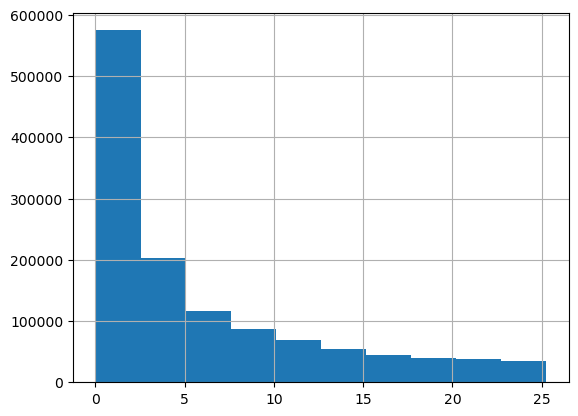

In [18]:
dat['YTIME'].hist()

## Shuffling Data to Take Random Sample of Records

In [19]:
subset_size = 250000

shufdat = dat.sample(frac=1, random_state=33)
shufdat = shufdat[~shufdat.duplicated(subset=['RIDVAL'])]
print(shufdat.shape)

ind_dat = shufdat.sample(subset_size, random_state = 33)
print(ind_dat.columns)

(524095, 120)
Index(['RIDVAL', 'BIRTHYEAR', 'GENDER', 'RACE', 'BIRTHCITY', 'BIRTHCOUNTY',
       'BIRTHSTATE', 'BIRTHCOUNTRY', 'CITIZENSHIPCODE', 'ETHNICCODE',
       ...
       'AGG_PRIOR_OTHER_SEXUAL_OFFENSE', 'AGG_PRIOR_OTHER_TRAFFIC_VIOLATIONS',
       'AGG_PRIOR_POST_RELEASE_OFFENSE', 'AGG_PRIOR_ROBBERY',
       'AGG_PRIOR_SEXUAL_ASSAULT', 'AGG_PRIOR_VIOLATION_SEX_OFFNS_CONDITIONS',
       'AGG_PRIOR_WEAPONS_OFFENSES', 'AGG_PRIOR_WORTHLESS_CHECKS', 'YTIME',
       'OBSERVED'],
      dtype='object', length=120)


In [20]:
ind_dat.shape

(250000, 120)

In [21]:
ind_dat.head()

,RIDVAL,BIRTHYEAR,GENDER,RACE,BIRTHCITY,BIRTHCOUNTY,BIRTHSTATE,BIRTHCOUNTRY,CITIZENSHIPCODE,ETHNICCODE,...,AGG_PRIOR_OTHER_SEXUAL_OFFENSE,AGG_PRIOR_OTHER_TRAFFIC_VIOLATIONS,AGG_PRIOR_POST_RELEASE_OFFENSE,AGG_PRIOR_ROBBERY,AGG_PRIOR_SEXUAL_ASSAULT,AGG_PRIOR_VIOLATION_SEX_OFFNS_CONDITIONS,AGG_PRIOR_WEAPONS_OFFENSES,AGG_PRIOR_WORTHLESS_CHECKS,YTIME,OBSERVED
2748293,RID0000753444,1976,MALE,BLACK,KINSTON,LENOIR,NORTH CAROLINA,UNITED STATES,BORN IN U.S.,AFRICAN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.025325,0
3106603,RID0001159781,1977,FEMALE,WHITE,ASHEBORO,RANDOLPH,NORTH CAROLINA,UNITED STATES,BORN IN U.S.,EUROPEAN/N.AM./AUSTR,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.673511,0
2871627,RID0000466771,1993,MALE,WHITE,NEW BERN,CRAVEN,NORTH CAROLINA,UNITED STATES,BORN IN U.S.,EUROPEAN/N.AM./AUSTR,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.128679,1
2376016,RID0001147195,1984,MALE,WHITE,WILMINGTON,NEW HANOVER,NORTH CAROLINA,UNITED STATES,BORN IN U.S.,UNKNOWN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.819302,0
1612658,RID0000882889,1967,MALE,BLACK,SALISBURY,ROWAN,NORTH CAROLINA,UNITED STATES,BORN IN U.S.,EUROPEAN/N.AM./AUSTR,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.686516,1


<AxesSubplot:>

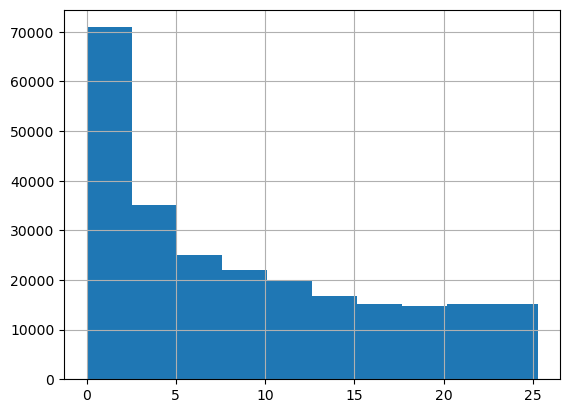

In [22]:
ind_dat['YTIME'].hist()

## Formatting for TF Model

In [23]:
def scale_var(x):
    return (x - x.mean()) / x.std()

In [24]:
ind_dat['MALE'] = np.where(ind_dat['GENDER'] == 'MALE', 1, 0)
ind_dat['FROMPRISON'] = np.where(ind_dat['PRISON_AFTER_CONVICTION'] == True, 1, 0)
ind_dat['COMMUNITY'] = np.where(ind_dat['PENALTY_ALL_DCC_COMMUNITY'] == True, 1, 0)

tf_dat = pd.concat([
    ind_dat['YTIME'],
    ind_dat['OBSERVED'],
    ind_dat['MALE'],
    ind_dat['RACE'],
    pd.get_dummies(ind_dat['RACE'], prefix='RACE', dtype='int64'),
#     ind_dat['YEAROFDATE'],
    ind_dat['FIRSTCONV_AGE'],
    ind_dat['AGEATDATE'],
    ind_dat['EVENTSBEFOREDATE'],
    ind_dat['N_PRIOR_FELONY'],
    ind_dat['N_PRIOR_MISD'],
    ind_dat['EVENTSONDATE'],
    ind_dat['N_FELONY'],
    ind_dat['N_MISD'],
    ind_dat['FROMPRISON'],
    ind_dat['INCTIME'],
    ind_dat['PRIOR_INCTIME'],
    ind_dat['PRIOR_PRISONSPELLS'],
    ind_dat['TOTAL_MIN_SENTENCE_TIME'],
    ind_dat['AVG_MIN_SENTENCE_TIME'],
    ind_dat['TOTAL_MAX_SENTENCE_TIME'],
    ind_dat['AVG_MAX_SENTENCE_TIME'],
    ind_dat['ANY_CONSECUTIVE'],
    ind_dat['ANY_CONCURRENT'],
    ind_dat['COMMUNITY'],
    ind_dat['PENALTY_COUNT_DWI'],
    ind_dat['AGG_DATE_ABANDONMENT_AND_NONSUPPORT'],
    ind_dat['AGG_DATE_ASSAULT'],
    ind_dat['AGG_DATE_AUTO_THEFT'],
    ind_dat['AGG_DATE_BREAKING_ENTERING'],
    ind_dat['AGG_DATE_BURGLARY'],
    ind_dat['AGG_DATE_BURNINGS'],
    ind_dat['AGG_DATE_DRIVING_WHILE_IMPAIRED'],
    ind_dat['AGG_DATE_DRUGS_TRAFFICK'],
    ind_dat['AGG_DATE_DRUGS_NON_TRAFFICK'],
    ind_dat['AGG_DATE_FORGERY'],
    ind_dat['AGG_DATE_FRAUD'],
    ind_dat['AGG_DATE_KIDNAPPING_AND_ABDUCTION'],
    ind_dat['AGG_DATE_LARCENY'],
    ind_dat['AGG_DATE_MANSLAUGHTER'],
    ind_dat['AGG_DATE_MURDER_FIRST_DEGREE'],
    ind_dat['AGG_DATE_MURDER_SECOND_DEGREE'],
    ind_dat['AGG_DATE_NOT_OBSERVED'],
    ind_dat['AGG_DATE_NOT_REPORTED_UNDEFINED'],
    ind_dat['AGG_DATE_OTHER_ALCOHOL_OFFENSE'],
    ind_dat['AGG_DATE_OTHER_OFFENSE_AGAINST_PERSON'],
    ind_dat['AGG_DATE_OTHER_PROPERTY'],
    ind_dat['AGG_DATE_OTHER_PUBLIC_ORDER'],
    ind_dat['AGG_DATE_OTHER_SEXUAL_OFFENSE'],
    ind_dat['AGG_DATE_OTHER_TRAFFIC_VIOLATIONS'],
    ind_dat['AGG_DATE_POST_RELEASE_OFFENSE'],
    ind_dat['AGG_DATE_ROBBERY'],
    ind_dat['AGG_DATE_SEXUAL_ASSAULT'],
    ind_dat['AGG_DATE_VIOLATION_SEX_OFFNS_CONDITIONS'],
    ind_dat['AGG_DATE_WEAPONS_OFFENSES'],
    ind_dat['AGG_DATE_WORTHLESS_CHECKS'],
    ind_dat['AGG_PRIOR_ABANDONMENT_AND_NONSUPPORT'],
    ind_dat['AGG_PRIOR_ASSAULT'],
    ind_dat['AGG_PRIOR_AUTO_THEFT'],
    ind_dat['AGG_PRIOR_BREAKING_ENTERING'],
    ind_dat['AGG_PRIOR_BURGLARY'],
    ind_dat['AGG_PRIOR_BURNINGS'],
    ind_dat['AGG_PRIOR_DRIVING_WHILE_IMPAIRED'],
    ind_dat['AGG_PRIOR_DRUGS_TRAFFICK'],
    ind_dat['AGG_PRIOR_DRUGS_NON_TRAFFICK'],
    ind_dat['AGG_PRIOR_FORGERY'],
    ind_dat['AGG_PRIOR_FRAUD'],
    ind_dat['AGG_PRIOR_KIDNAPPING_AND_ABDUCTION'],
    ind_dat['AGG_PRIOR_LARCENY'],
    ind_dat['AGG_PRIOR_MANSLAUGHTER'],
    ind_dat['AGG_PRIOR_MURDER_FIRST_DEGREE'],
    ind_dat['AGG_PRIOR_MURDER_SECOND_DEGREE'],
    ind_dat['AGG_PRIOR_NOT_OBSERVED'],
    ind_dat['AGG_PRIOR_NOT_REPORTED_UNDEFINED'],
    ind_dat['AGG_PRIOR_OTHER_ALCOHOL_OFFENSE'],
    ind_dat['AGG_PRIOR_OTHER_OFFENSE_AGAINST_PERSON'],
    ind_dat['AGG_PRIOR_OTHER_PROPERTY'],
    ind_dat['AGG_PRIOR_OTHER_PUBLIC_ORDER'],
    ind_dat['AGG_PRIOR_OTHER_SEXUAL_OFFENSE'],
    ind_dat['AGG_PRIOR_OTHER_TRAFFIC_VIOLATIONS'],
    ind_dat['AGG_PRIOR_POST_RELEASE_OFFENSE'],
    ind_dat['AGG_PRIOR_ROBBERY'],
    ind_dat['AGG_PRIOR_SEXUAL_ASSAULT'],
    ind_dat['AGG_PRIOR_VIOLATION_SEX_OFFNS_CONDITIONS'],
    ind_dat['AGG_PRIOR_WEAPONS_OFFENSES'],
    ind_dat['AGG_PRIOR_WORTHLESS_CHECKS']
], axis = 1,
)
tf_dat.head()

,YTIME,OBSERVED,MALE,RACE,RACE_ASIAN/ORTL,RACE_BLACK,RACE_INDIAN,RACE_OTHER,RACE_UNKNOWN,RACE_WHITE,...,AGG_PRIOR_OTHER_PROPERTY,AGG_PRIOR_OTHER_PUBLIC_ORDER,AGG_PRIOR_OTHER_SEXUAL_OFFENSE,AGG_PRIOR_OTHER_TRAFFIC_VIOLATIONS,AGG_PRIOR_POST_RELEASE_OFFENSE,AGG_PRIOR_ROBBERY,AGG_PRIOR_SEXUAL_ASSAULT,AGG_PRIOR_VIOLATION_SEX_OFFNS_CONDITIONS,AGG_PRIOR_WEAPONS_OFFENSES,AGG_PRIOR_WORTHLESS_CHECKS
2748293,11.025325,0,1,BLACK,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3106603,0.673511,0,0,WHITE,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2871627,0.128679,1,1,WHITE,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2376016,15.819302,0,1,WHITE,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1612658,1.686516,1,1,BLACK,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
tf_dat['AVG_MAX_SENTENCE_TIME'].isnull().sum()

0

In [26]:
np.sum(dat['YTIME']==0)

0

In [27]:
tf_dat['RACE_WHITE'].mean()

0.471544

In [29]:
tf_dat.select_dtypes(include=['int', 'float']).mean()

YTIME                                       8.933800
OBSERVED                                    0.352968
MALE                                        0.740256
RACE_ASIAN/ORTL                             0.000648
RACE_BLACK                                  0.496404
                                              ...   
AGG_PRIOR_ROBBERY                           0.049672
AGG_PRIOR_SEXUAL_ASSAULT                    0.006180
AGG_PRIOR_VIOLATION_SEX_OFFNS_CONDITIONS    0.000268
AGG_PRIOR_WEAPONS_OFFENSES                  0.000028
AGG_PRIOR_WORTHLESS_CHECKS                  0.086800
Length: 89, dtype: float64

In [30]:
for i, tm in enumerate(tf_dat.select_dtypes(include=['int', 'float']).mean()):
    print('{:<40} {:>15}'.format(tf_dat.columns[i], round(tm,3)))

YTIME                                              8.934
OBSERVED                                           0.353
MALE                                                0.74
RACE                                               0.001
RACE_ASIAN/ORTL                                    0.496
RACE_BLACK                                         0.024
RACE_INDIAN                                        0.006
RACE_OTHER                                         0.002
RACE_UNKNOWN                                       0.472
RACE_WHITE                                        27.262
FIRSTCONV_AGE                                     32.719
AGEATDATE                                          2.347
EVENTSBEFOREDATE                                    0.87
N_PRIOR_FELONY                                     1.477
N_PRIOR_MISD                                       1.384
EVENTSONDATE                                       0.533
N_FELONY                                           0.851
N_MISD                         

# TF Mixture of Experts Model

### Subsetting into Train/Val/Test Splits

In [31]:
# RACE_ASIAN/ORTL                                 0.000648
# RACE_BLACK                                      0.496404
# RACE_INDIAN                                     0.023776
# RACE_OTHER                                      0.006064
# RACE_UNKNOWN                                     0.00156
# RACE_WHITE                                      0.471544

# dat_copy.pop below removes the race and gender variables from that df
class xydat:
    def __init__(self, dat):
        dat_copy = dat.copy()
        self.Y = dat_copy[['YTIME','OBSERVED']].copy()
        self.RACEGENDER = dat_copy[['RACE',
                                    'RACE_ASIAN/ORTL', 
                                    'RACE_BLACK',
                                    'RACE_INDIAN',
                                    'RACE_OTHER',
                                    'RACE_UNKNOWN',
                                    'RACE_WHITE',
                                    'MALE']]
        [dat_copy.pop(x) for x in ['YTIME',
                                   'OBSERVED',
                                   'RACE',
                                   'RACE_ASIAN/ORTL', 
                                   'RACE_BLACK',
                                   'RACE_INDIAN',
                                   'RACE_OTHER',
                                   'RACE_UNKNOWN',
                                   'RACE_WHITE',
                                   'MALE']]
        self.X = dat_copy

TRAIN, TEST = train_test_split(tf_dat, test_size=0.2, random_state=42)
TRAIN, VAL = train_test_split(TRAIN, test_size=0.2, random_state=42)
TRAIN = xydat(TRAIN)
TEST = xydat(TEST)
VAL = xydat(VAL)

### Training the model

In [33]:
np.mean(1./(0.05 + TRAIN.Y['YTIME']))

0.739103038154684

In [ ]:
modm = tf_surv_mixmodel(max_time = 3 * TRAIN.Y['YTIME'].max(), 
                        n_shapes=30, 
                        n_nodes=1024, 
                        n_means=100, 
#                         step_size=5e-3,
                        step_size=1e-2,
                        p_dropout = 0.25)
cb = keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True)
historym = modm.model.fit(TRAIN.X, TRAIN.Y,
                          batch_size = 100,
                          validation_data = (VAL.X, VAL.Y),
                          epochs = 5000, callbacks = cb)

2023-02-08 21:28:53.064800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 21:28:53.912872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14536 MB memory:  -> device: 0, name: Tesla P6, pci bus id: 0000:d8:00.0, compute capability: 6.1


Epoch 1/5000
  84/1600 [>.............................] - ETA: 1:19 - loss: 2.1835

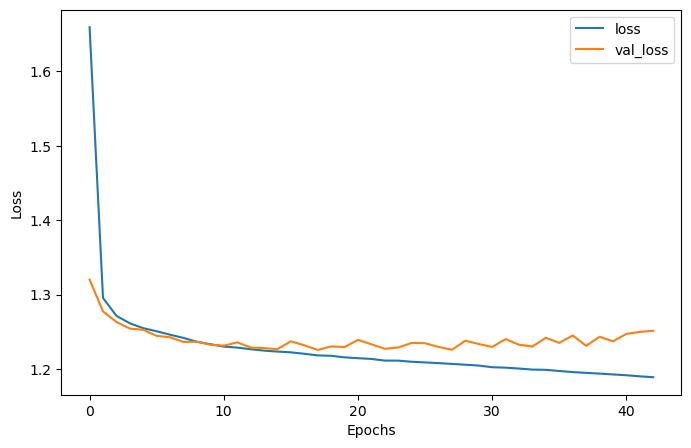

In [35]:
fig = pd.DataFrame(historym.history).plot().get_figure()
fig.set_size_inches([8,5])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [36]:
modm.model.evaluate(TEST.X, TEST.Y)

1563/1563 [==============================] - 21s 13ms/step - loss: 1.2286


1.2286456823349

In [38]:
LOSS = pd.DataFrame(historym.history)
LOSS['TEST'] = modm.model.evaluate(TEST.X, TEST.Y)

1563/1563 [==============================] - 20s 13ms/step - loss: 1.2286


In [39]:
LOSS.to_csv(
    path.join(
        here(),
        'reset_project_data/2021-06-09-rr-wrace--training-val-test-losses.csv'))

### Checking Calibrations

#### Training Calibrations 

TRAINING
5000/5000 [==============================] - 5s 923us/step
0
30.14352720564616 255.20220939727056 REJ 252.99987370790933 REJ


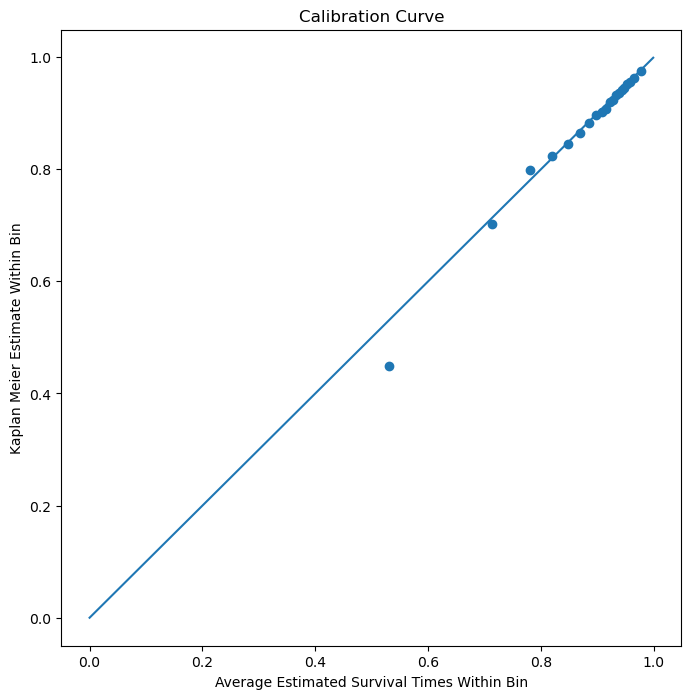

5000/5000 [==============================] - 5s 909us/step
0
30.14352720564616 258.7922251172115 REJ 269.21067810893885 REJ


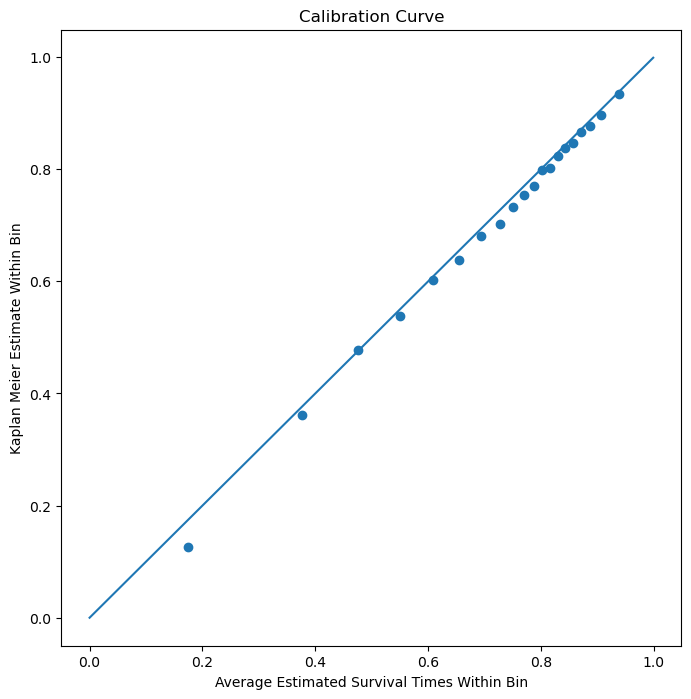

5000/5000 [==============================] - 5s 947us/step
0
30.14352720564616 222.71582309522972 REJ 193.4714482019978 REJ


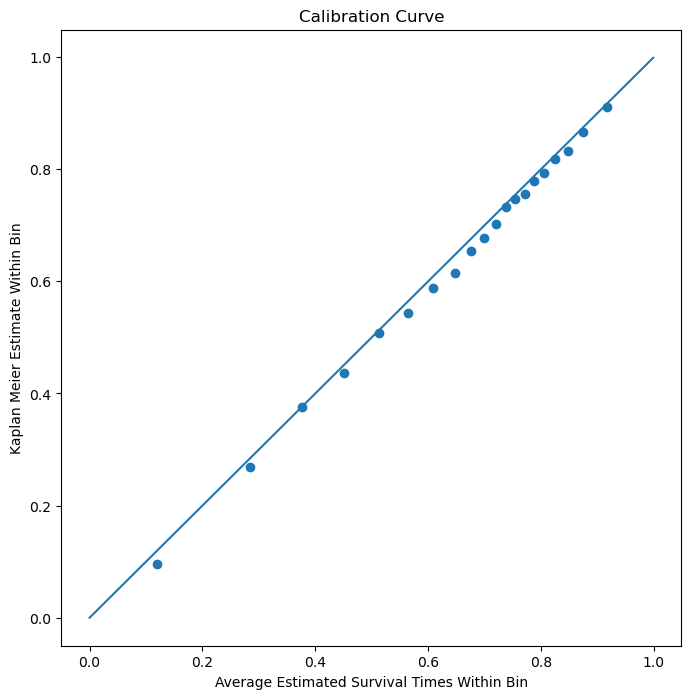

5000/5000 [==============================] - 5s 944us/step
0
30.14352720564616 267.2505416696709 REJ 187.75601439108092 REJ


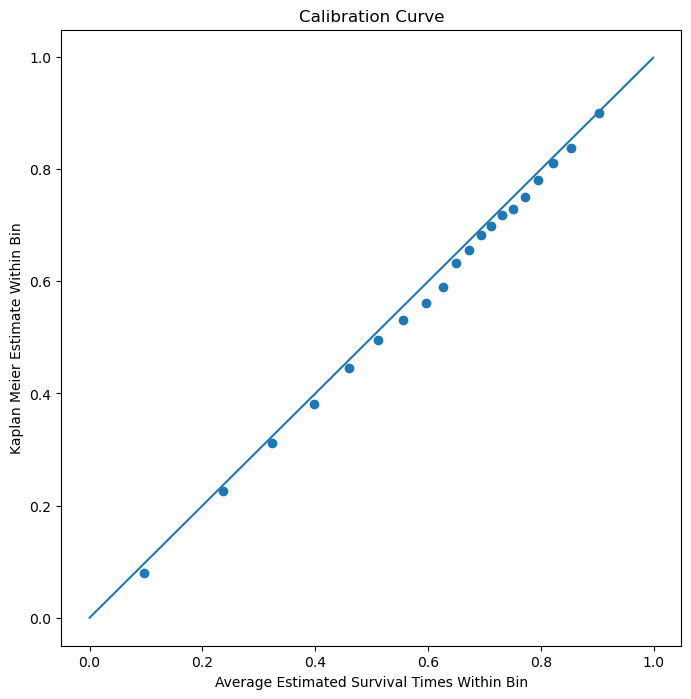

VALIDATION
1250/1250 [==============================] - 1s 1ms/step
0
30.14352720564616 115.25721811614244 REJ 109.29149427844226 REJ


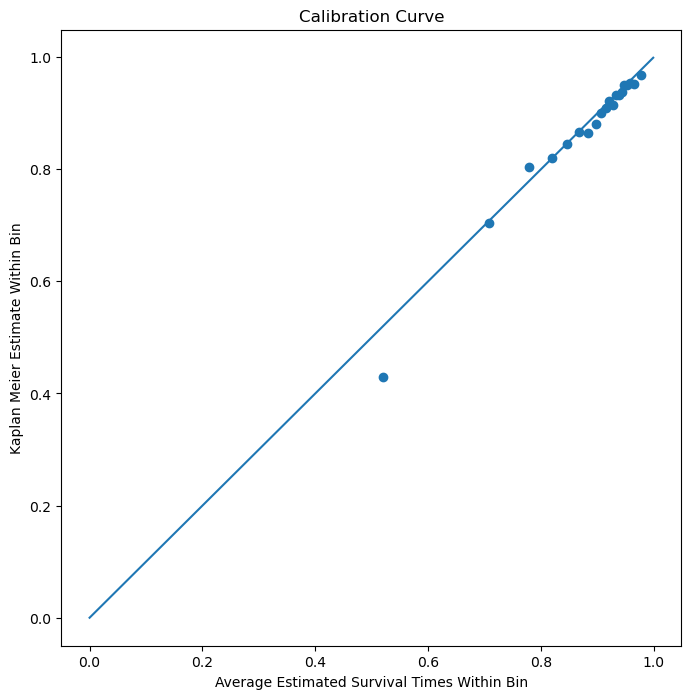

1250/1250 [==============================] - 1s 998us/step
0
30.14352720564616 93.974623436148 REJ 81.64535690157854 REJ


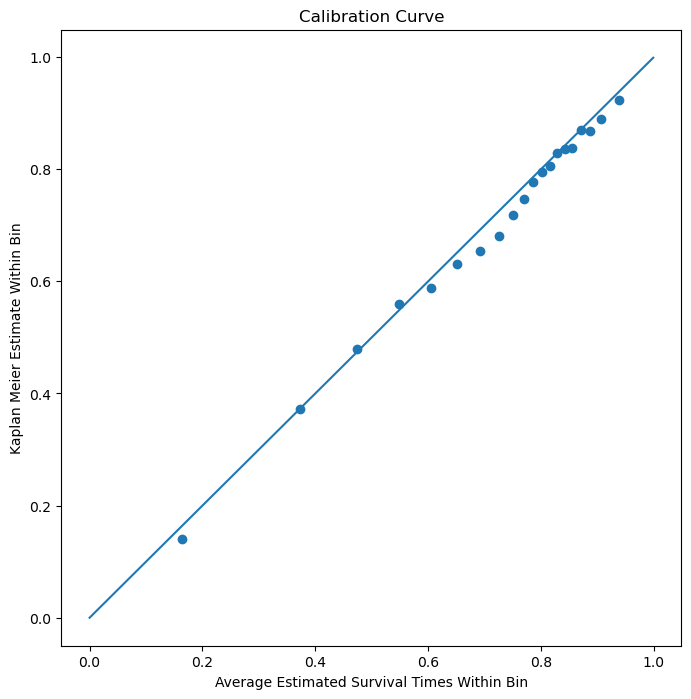

1250/1250 [==============================] - 3s 2ms/step
0
30.14352720564616 103.85351604813359 REJ 82.57051462023155 REJ


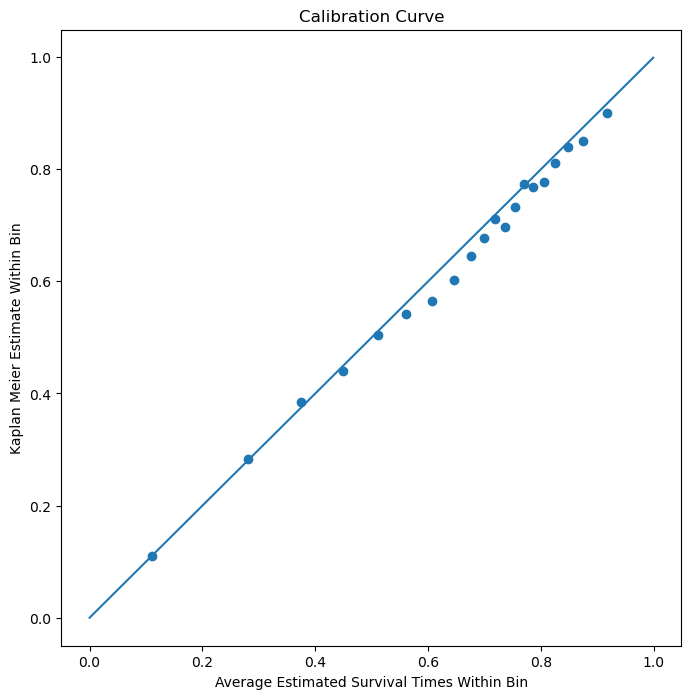

1250/1250 [==============================] - 1s 944us/step
0
30.14352720564616 112.25506824010812 REJ 75.11812111003242 REJ


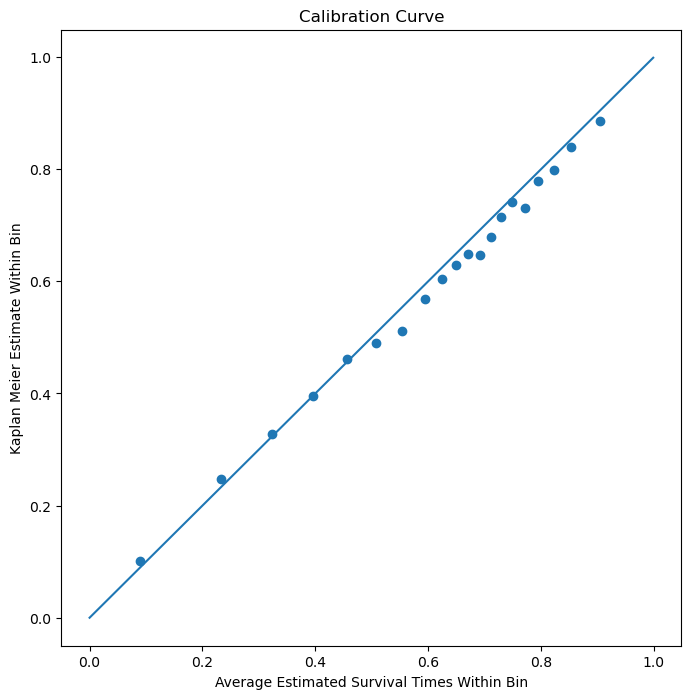

TEST
1563/1563 [==============================] - 2s 899us/step
0
30.14352720564616 99.35866537767247 REJ 95.75553803378071 REJ


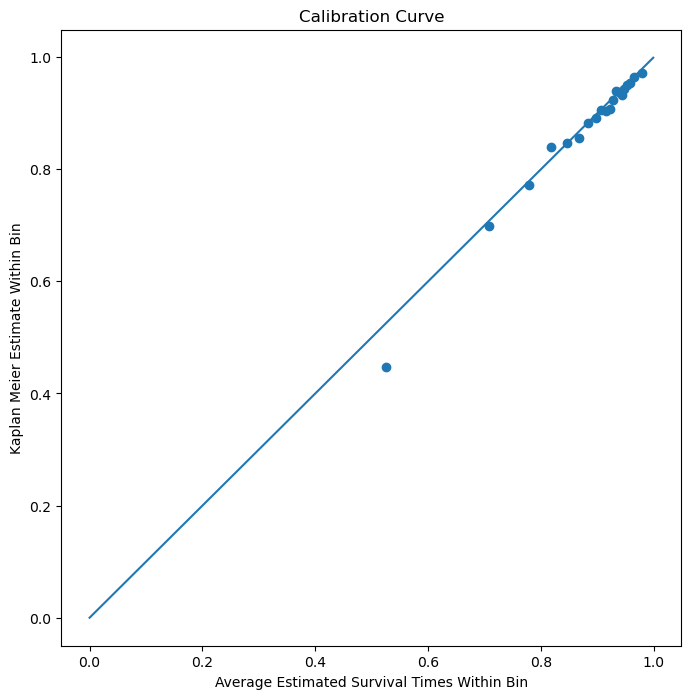

1563/1563 [==============================] - 2s 989us/step
0
30.14352720564616 88.72812955290017 REJ 80.95555867770595 REJ


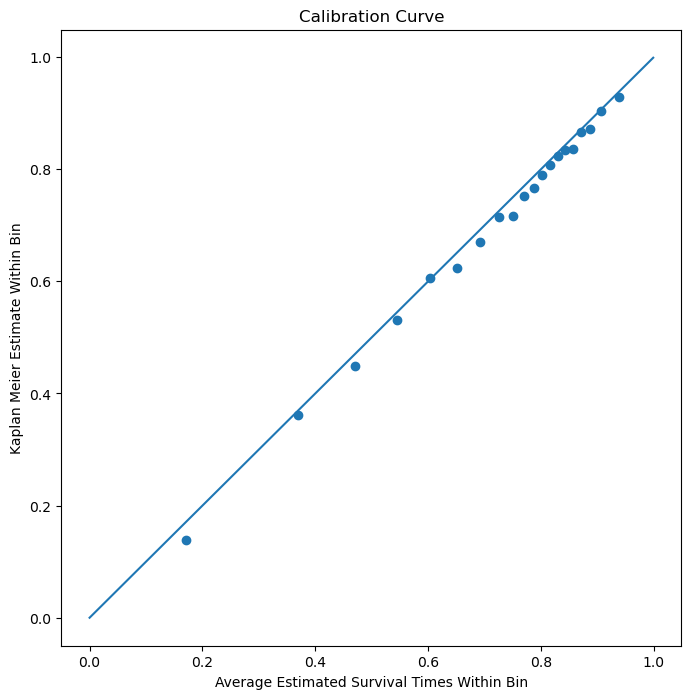

1563/1563 [==============================] - 1s 924us/step
0
30.14352720564616 107.19230333448695 REJ 86.03587742738262 REJ


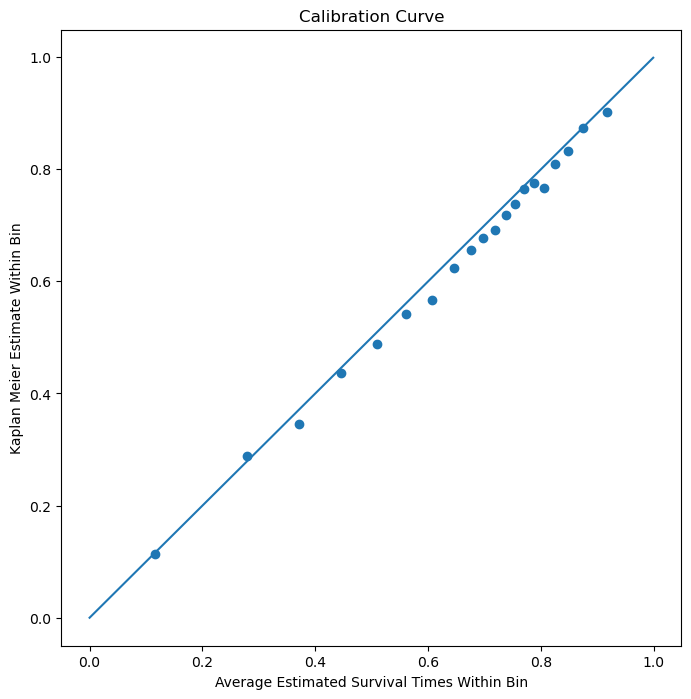

1563/1563 [==============================] - 1s 828us/step
0
30.14352720564616 112.45663464887112 REJ 77.12997369276978 REJ


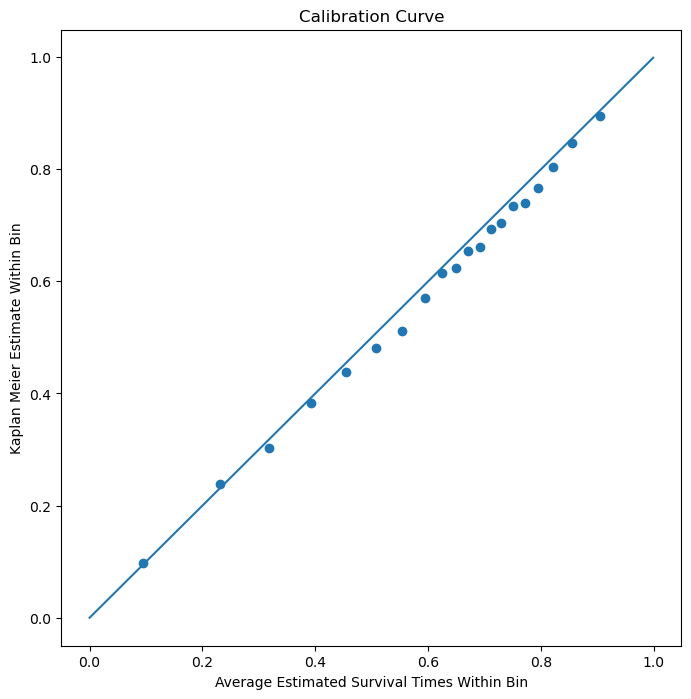

In [41]:
nbins = 20
tpts = [1,5,10,20]

print("TRAINING")
for tpt in tpts:
    test_preds = modm.predict_surv(TRAIN.X, tpt)
    Z = km_surv_cal(test_preds,
                    TRAIN.Y['YTIME'], 
                    TRAIN.Y['OBSERVED'],
                    n_bins=nbins,
                    time_window=tpt)
    Z.to_csv(
        path.join(
            here(),
            'reset_project_data/2021-06-09-wrace-train_cal_' + str(tpt)+ 'yearsurv.csv'))
    
print("VALIDATION")
for tpt in tpts:
    test_preds = modm.predict_surv(VAL.X, tpt)
    Z = km_surv_cal(test_preds,
                    VAL.Y['YTIME'], 
                    VAL.Y['OBSERVED'],
                    n_bins=nbins,
                    time_window=tpt)
    Z.to_csv(
        path.join(
            here(),
            'reset_project_data/2021-06-09-wrace-val_cal_' + str(tpt)+ 'yearsurv.csv'))
    
print("TEST")
for tpt in tpts:
    test_preds = modm.predict_surv(TEST.X, tpt)
    Z = km_surv_cal(test_preds,
                    TEST.Y['YTIME'], 
                    TEST.Y['OBSERVED'],
                    n_bins=nbins,
                    time_window=tpt)
    Z.to_csv(
        path.join(
            here(),
            'reset_project_data/2021-06-09-wrace-test_cal_' + str(tpt)+ 'yearsurv.csv')

In [42]:
Z

,KM,ESTS,TST
0,0.096848,0.093816,0.190374
1,0.238944,0.231547,0.556242
2,0.303424,0.318059,1.839517
3,0.383014,0.392434,0.678705
4,0.438166,0.454757,1.975675
5,0.480362,0.507463,5.194591
6,0.511217,0.553883,12.575787
7,0.569538,0.594371,4.349443
8,0.615080,0.625470,0.837529
9,0.624322,0.648871,4.634076


1563/1563 [==============================] - 1s 792us/step
0
16.918977604620448 62.84263440078544 REJ 58.88281199066462 REJ


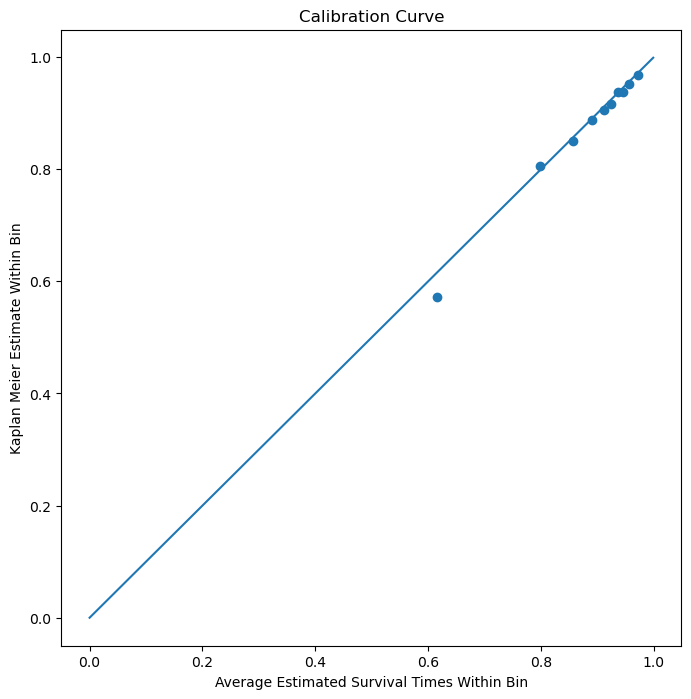

1563/1563 [==============================] - 1s 783us/step
0
16.918977604620448 76.54379346936113 REJ 72.2476982623687 REJ


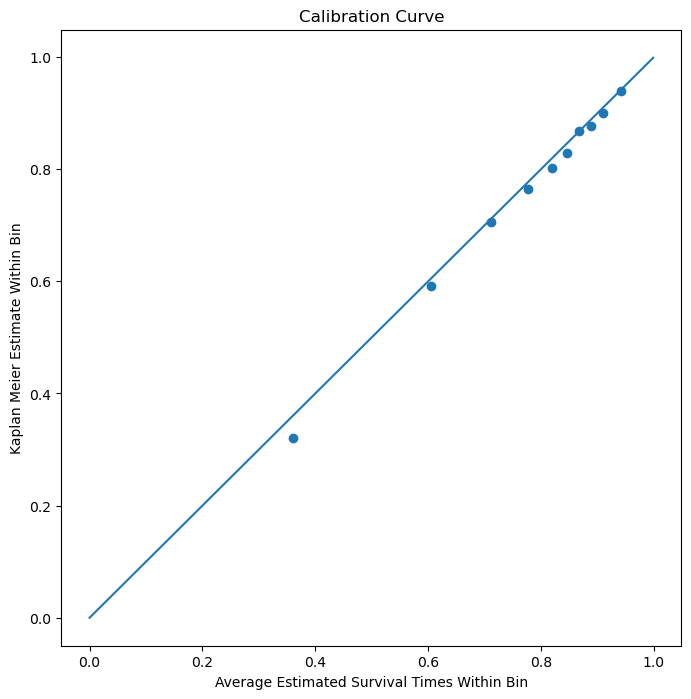

1563/1563 [==============================] - 1s 876us/step
0
16.918977604620448 67.55747271790204 REJ 60.57002886925338 REJ


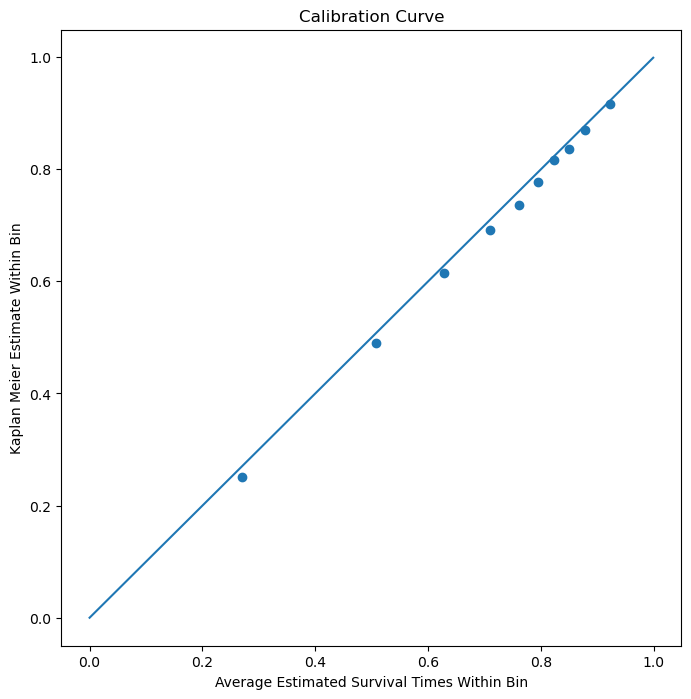

1563/1563 [==============================] - 1s 786us/step
0
16.918977604620448 91.38000207834526 REJ 74.70025000877118 REJ


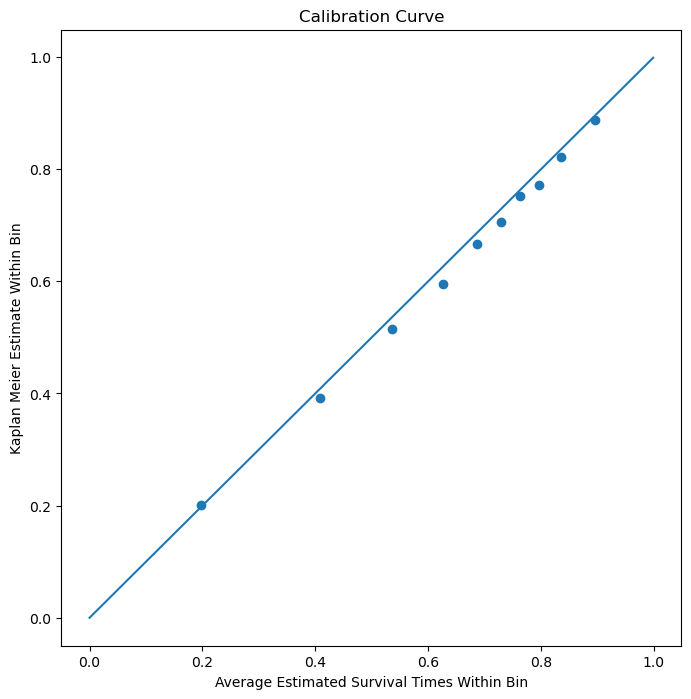

1563/1563 [==============================] - 1s 819us/step
0
16.918977604620448 98.13421643656557 REJ 73.74599413704443 REJ


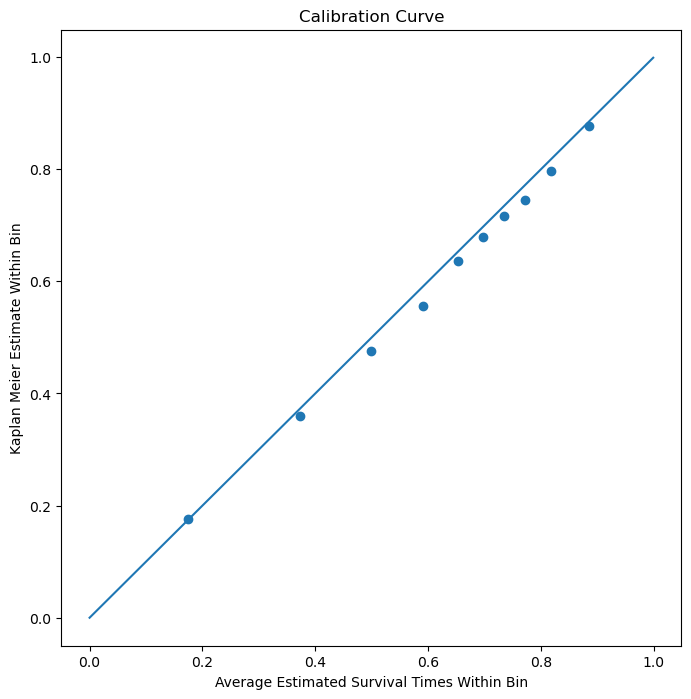

1563/1563 [==============================] - 1s 816us/step
0
16.918977604620448 103.43704100141296 REJ 71.32968404691707 REJ


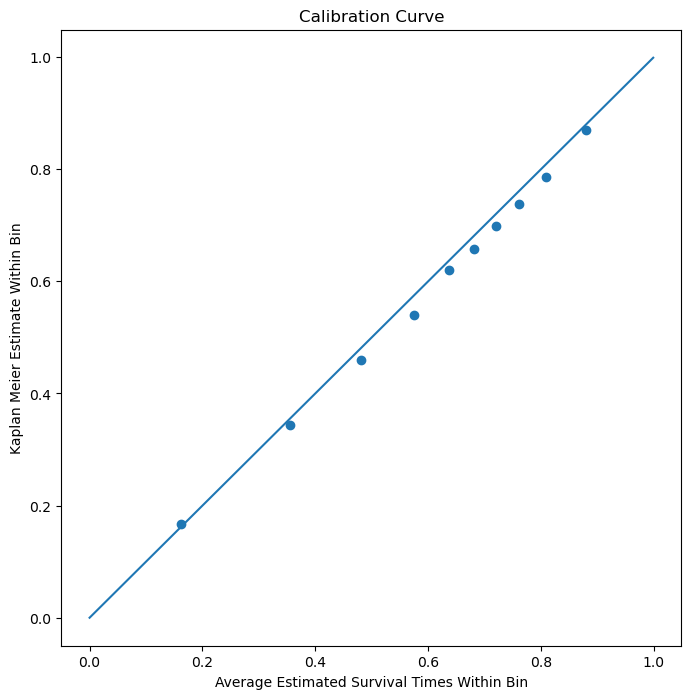

In [43]:
tpts = [1,3,5,10,15,20]

for tpt in tpts:
    test_preds = modm.predict_surv(TEST.X, tpt)
    km_surv_cal(test_preds,
                TEST.Y['YTIME'], 
                TEST.Y['OBSERVED'],
                n_bins=10,
                time_window=tpt)

### C-Index

In [44]:
TEST.Y

,YTIME,OBSERVED
2497535,0.054757,1
439328,18.595483,0
2013312,18.223135,0
1597642,1.579740,1
2490779,3.400411,0
...,...,...
2567722,2.822724,1
1272806,13.327858,0
1552846,19.890486,0
1892832,0.147844,1


In [45]:
def cindex(dset, tpt):
    return concordance_index_censored(dset.Y['OBSERVED']==1, 
                                      dset.Y['YTIME'],
                                      1.-modm.predict_surv(dset.X,tpt))[0]
CVALS = [cindex(TEST, tpt) for tpt in np.arange(0,26,1)]

1563/1563 [==============================] - 1s 800us/step


In [46]:
print(cindex(TRAIN, 1), cindex(VAL, 1), cindex(TEST, 1))
print(cindex(TRAIN, 5), cindex(VAL, 5), cindex(TEST, 5))
print(cindex(TRAIN, 10), cindex(VAL, 10), cindex(TEST, 10))

1563/1563 [==============================] - 1s 845us/step
0.7030388857935463 0.6977304412698256 0.7014235140704849
1563/1563 [==============================] - 1s 844us/step
0.707308303084416 0.7017541808618813 0.7056025957514879
1563/1563 [==============================] - 1s 908us/step
0.7062736218832384 0.7003388669979445 0.7043764345568001


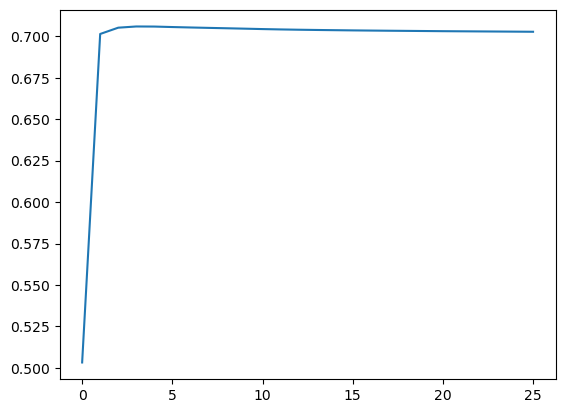

In [47]:
plt.plot(np.arange(0,26,1), CVALS)
plt.show()

In [48]:
CVALS

[0.5032232410941667,
 0.7014235140704849,
 0.7052169014749875,
 0.7059452851874747,
 0.7058941838554914,
 0.7056025957514879,
 0.7053429512238156,
 0.7051015293318198,
 0.7048694647415057,
 0.7046265707601518,
 0.7043764345568001,
 0.7041623897131628,
 0.7039852988888587,
 0.7038385918363587,
 0.7037103141222377,
 0.7035838135937149,
 0.7034801434168336,
 0.7033768340162562,
 0.7032881440647604,
 0.7032022083695715,
 0.7031076399762709,
 0.7030340248299951,
 0.7029652431709019,
 0.7028985239623914,
 0.7028287766736986,
 0.7027583581732776]

## Permutation Variable Importance

In [49]:
def perm_bycolumns(mod, X, y, ind, baseline_val, seed_state, fval = 1):
    XSAMP = X.copy()
    ysamp = y.copy()
    n_obs = XSAMP.shape[0]
    XSAMP[XSAMP.columns[ind]] = XSAMP[XSAMP.columns[ind]].sample(frac=1, random_state=seed_state).values
    perm_value = mod.evaluate(XSAMP, ysamp, batch_size = 100, verbose = 1)
    return 100 * (perm_value / baseline_val - 1.)

def perm_outcome(mod, X, y, baseline_val, seed_state, fval = 1):
    XSAMP = X.copy()
    ysamp = y.copy()
    ysamp = ysamp.sample(frac=1, random_state=seed_state)
    perm_value = mod.evaluate(XSAMP, ysamp, batch_size = 100, verbose = 1)
    return 100 * (perm_value / baseline_val - 1.)

In [52]:
def pattern_match_cols(pattern, X):
    return [i  for (i,x) in enumerate(X.columns) if pattern in x]

In [53]:
baseline_value = modm.model.evaluate(TEST.X, TEST.Y, batch_size=100, verbose = 1)
max_change = perm_outcome(modm.model,TEST.X, TEST.Y, baseline_value, 55)

gender_cols = pattern_match_cols('MALE', TEST.X)
age_cols = [i for (i,x) in enumerate(TEST.X.columns) if x in ['FIRSTCONV_AGE','AGEATDATE']]
race_cols = pattern_match_cols('RACE', TEST.X)
prior_cols = [i for (i,x) in enumerate(TEST.X.columns) if x in ['EVENTSBEFOREDATE','N_PRIOR_FELONY', 'N_PRIOR_MISD']]
eventcount_cols = [i for (i,x) in enumerate(TEST.X.columns) if x in ['EVENTSONDATE','N_FELONY', 'N_MISD']]
prison_cols = [i for (i,x) in enumerate(TEST.X.columns) if x in ['FROMPRISON', 'INCTIME', 'COMMUNITY']]
priorprison_cols = [i for (i,x) in enumerate(TEST.X.columns) if x in ['PRIOR_INCTIME','PRIOR_PRISONSPELLS']]
minmax_cols = [i for (i,x) in enumerate(TEST.X.columns) if x in ['TOTAL_MIN_SENTENCE_TIME', 'AVG_MIN_SENTENCE_TIME', 'TOTAL_MAX_SENTENCE_TIME', 'AVG_MAX_SENTENCE_TIME', 'ANY_CONSECUTIVE', 'ANY_CONCURRENT']]
aggdate_cols = pattern_match_cols('AGG_DATE', TEST.X)
aggprior_cols = pattern_match_cols('AGG_PRIOR', TEST.X)

group_names = [
    'Gender',
    'Age',
    'Race',
    'NEvents - Prior',
    'NEvents - Current',
    'Prison Info - Current',
    'Prison Info - Prior',
    'Sentence Info',
    'Offense Type - Current',
    'Offense Type - Prior'
]

col_inds = [gender_cols, 
            age_cols,
            race_cols,
            prior_cols,
            eventcount_cols,
            prison_cols,
            priorprison_cols,
            minmax_cols,
            aggdate_cols,
            aggprior_cols]
col_inds

def pmi(ci):
    return perm_bycolumns(modm.model, 
                          TEST.X, TEST.Y, 
                          ci, 
                          baseline_value, 
                          105, fval = 1)



IMPS = dict([(group_names[i], pmi(ci)) for (i,ci) in enumerate(col_inds)])
IMPS.update({'Permuted Outcome':max_change})
P = {k: v for k, v in sorted(IMPS.items(), key=lambda item: item[1], reverse=True)}

500/500 [==============================] - 19s 39ms/step - loss: 1.2544


In [54]:
P

{'Permuted Outcome': 19.97694492843729,
 'Prison Info - Current': 5.528802539259692,
 'Age': 4.560755382023185,
 'NEvents - Current': 4.2719217714895175,
 'NEvents - Prior': 2.4291557683377762,
 'Sentence Info': 2.306981935698449,
 'Offense Type - Prior': 2.095467517692007,
 'Offense Type - Current': 1.1866249925048145,
 'Prison Info - Prior': 0.08391688996962632,
 'Gender': 0.0,
 'Race': 0.0}

In [55]:
# def perm_imp(mod, X, y, seed_state = 42):
#     nvars = X.shape[1]
#     baseline_value = mod.evaluate(X, y, batch_size=100, verbose = 0)
#     p_imp = [perm_bycolumns(mod, X, y, i, baseline_value, seed_state) for i in np.arange(0, nvars)]
#     return(dict(zip(X.columns, p_imp)))

# allIMPS = perm_imp(modm.model, VAL.X, VAL.Y, 55)

In [56]:
# allP = {k: v for k, v in sorted(allIMPS.items(), key=lambda item: item[1], reverse=True)}
# allP

# Subset Analysis - Race/Gender 

In [57]:
dset = TRAIN
group_ind = TRAIN.RACEGENDER['RACE_BLACK'] == 1
tpt = 5 

obs_ind = dset.Y['OBSERVED']==1
obs_times = dset.Y['YTIME']
risks = 1.-modm.predict_surv(dset.X,tpt)

concordance_index_censored(obs_ind[group_ind], obs_times[group_ind], risks[group_ind])

5000/5000 [==============================] - 5s 914us/step


(0.7100307836004482, 1224573713, 500028789, 251616, 168086)

In [58]:
risks

array([0.6131817 , 0.8581381 , 0.16450149, ..., 0.14288539, 0.15039349,
       0.11532021], dtype=float32)

In [59]:
def group_cindex(dset, group_ind, tpt):
    obs_ind = dset.Y['OBSERVED']==1
    obs_times = dset.Y['YTIME']
    risks = 1.-modm.predict_surv(dset.X,tpt)
    return concordance_index_censored(obs_ind[group_ind], obs_times[group_ind], risks[group_ind])[0]

WIND = TEST.RACEGENDER['RACE'] == 'WHITE'
BIND = TEST.RACEGENDER['RACE'] == 'BLACK'
OIND = ~((TEST.RACEGENDER['RACE'] == 'WHITE') | (TEST.RACEGENDER['RACE'] == 'BLACK'))
MIND = TEST.RACEGENDER['MALE'] == 1
FIND = TEST.RACEGENDER['MALE'] == 0

print(cindex(TEST, 3))
print(group_cindex(TEST, WIND, 3))
print(group_cindex(TEST, BIND, 3))
print(group_cindex(TEST, OIND, 3))
print(group_cindex(TEST, MIND, 3))
print(group_cindex(TEST, FIND, 3))


1563/1563 [==============================] - 1s 741us/step
0.7059452851874747
1563/1563 [==============================] - 2s 1ms/step
0.7074499930043415
1563/1563 [==============================] - 2s 981us/step
0.7044455782421599
1563/1563 [==============================] - 1s 750us/step
0.6855693110009632
1563/1563 [==============================] - 1s 755us/step
0.7054024219582257
1563/1563 [==============================] - 2s 1ms/step
0.6889623906671691


### Calibrations by group

In [60]:
print(WIND.sum())
print(BIND.sum())
print(OIND.sum())
print(WIND.sum() + BIND.sum() + OIND.sum())

23515
24896
1589
50000


1563/1563 [==============================] - 2s 973us/step
0
16.918977604620448 59.64730810514515 REJ 53.72797074396843 REJ
0
16.918977604620448 24.438701830412054 REJ 23.97511494361519 REJ
0
16.918977604620448 13.412262916608363 FTR 12.302374476647353 FTR


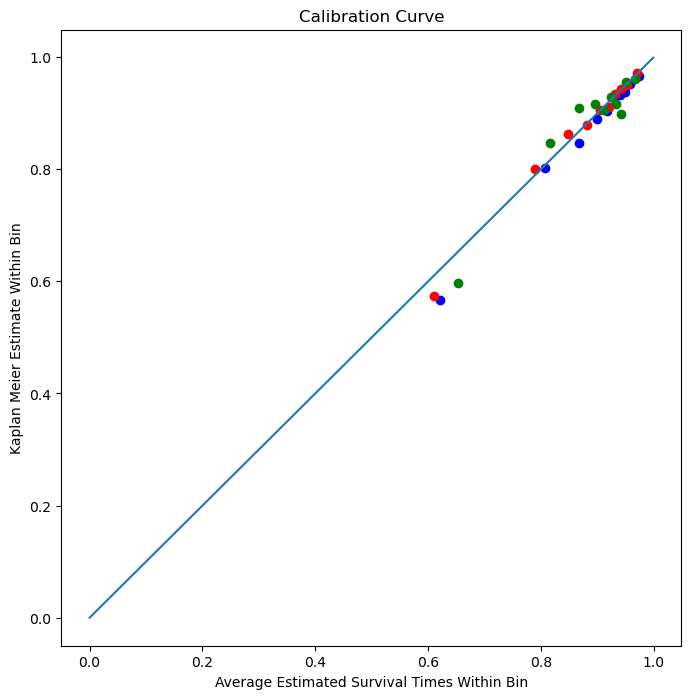

1563/1563 [==============================] - 2s 1ms/step
0
16.918977604620448 44.106733721435376 REJ 40.07292436193798 REJ
0
16.918977604620448 40.422017916823556 REJ 38.36474533667886 REJ
0
16.918977604620448 8.571315840504228 FTR 7.263216550789022 FTR


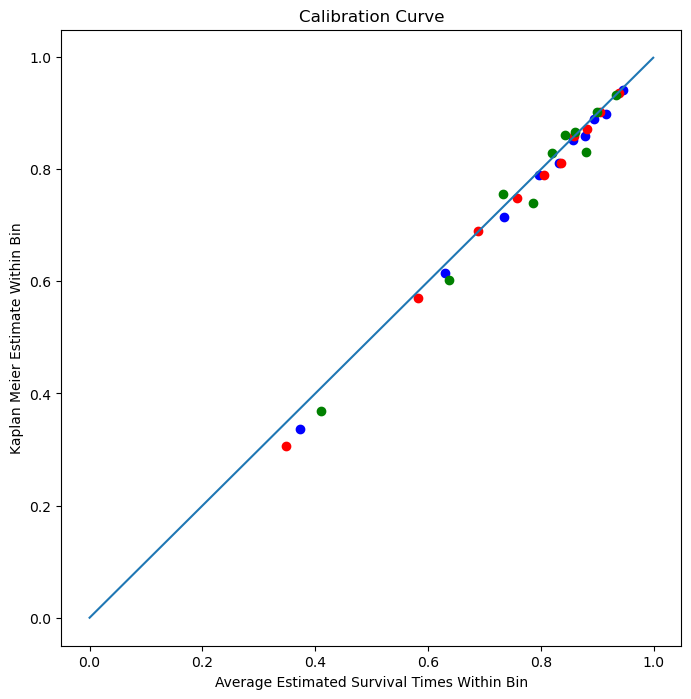

1563/1563 [==============================] - 1s 858us/step
0
16.918977604620448 25.404135505936217 REJ 22.451614000874137 REJ
0
16.918977604620448 58.181348308243265 REJ 51.33902274273291 REJ
0
16.918977604620448 6.030497309295777 FTR 4.942259241505361 FTR


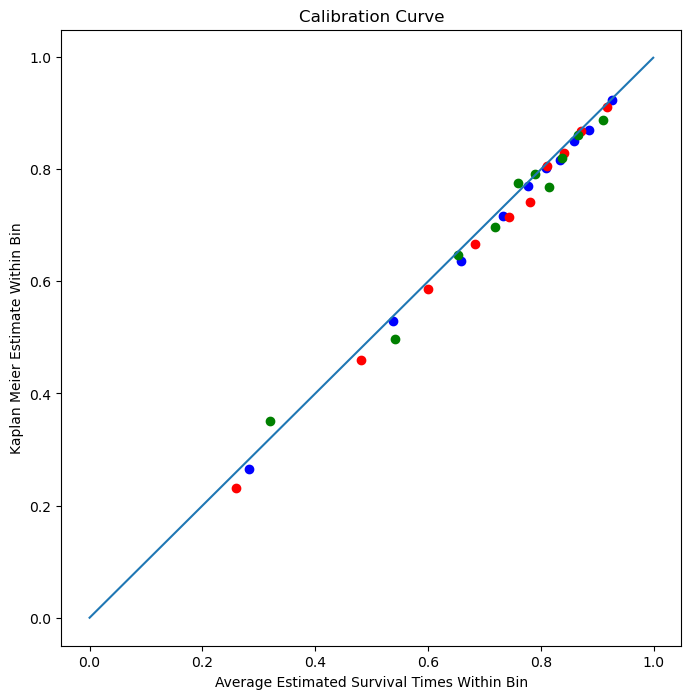

In [62]:
WIND = TEST.RACEGENDER['RACE'] == 'WHITE'
BIND = TEST.RACEGENDER['RACE'] == 'BLACK'
OIND = ~((TEST.RACEGENDER['RACE'] == 'WHITE') | (TEST.RACEGENDER['RACE'] == 'BLACK'))
MIND = TEST.RACEGENDER['MALE'] == 1
FIND = TEST.RACEGENDER['MALE'] == 0
tpts = [1.,3.,5.]
for tpt in tpts:
    test_preds = modm.predict_surv(TEST.X, tpt)
    WCAL = km_surv_cal(test_preds[WIND],
                    TEST.Y['YTIME'][WIND], 
                    TEST.Y['OBSERVED'][WIND],
                    n_bins=10,
                    time_window=tpt,
                    plot_cal=False)
    WCAL.to_csv(
        path.join(
            here(),
            'reset_project_data/2021-06-09-wrace-white-test_cal_' + str(tpt)+ 'yearsurv.csv'))
    BCAL = km_surv_cal(test_preds[BIND],
                    TEST.Y['YTIME'][BIND], 
                    TEST.Y['OBSERVED'][BIND],
                    n_bins=10,
                    time_window=tpt,
                    plot_cal=False)
    BCAL.to_csv(
        path.join(
            here(),
            'reset_project_data/2021-06-09-wrace-black-test_cal_' + str(tpt)+ 'yearsurv.csv'))
    OCAL = km_surv_cal(test_preds[OIND],
                    TEST.Y['YTIME'][OIND], 
                    TEST.Y['OBSERVED'][OIND],
                    n_bins=10,
                    time_window=tpt,
                    plot_cal=False)
    OCAL.to_csv(
        path.join(
            here(),'reset_project_data/2021-06-09-wrace-other-test_cal_' + str(tpt)+ 'yearsurv.csv'))
    
    fig, ax = plt.subplots()
    fig.set_size_inches([8,8])
    ax.plot(np.arange(0,1,0.001),np.arange(0,1,0.001))
    ax.scatter(WCAL['ESTS'],
               WCAL['KM'], 
               color = 'blue')
    ax.scatter(BCAL['ESTS'],
               BCAL['KM'], 
               color = 'red')
    ax.scatter(OCAL['ESTS'],
               OCAL['KM'], 
               color = 'green')
    
    plt.xlabel('Average Estimated Survival Times Within Bin')
    plt.ylabel('Kaplan Meier Estimate Within Bin')
    plt.title('Calibration Curve')
    plt.show()
    

5000/5000 [==============================] - 4s 835us/step
0
16.918977604620448 183.12803702600448 REJ 166.95553635374964 REJ
0
16.918977604620448 72.90027781177044 REJ 73.6782617178519 REJ
0
16.918977604620448 10.897219839234365 FTR 10.040210087010466 FTR


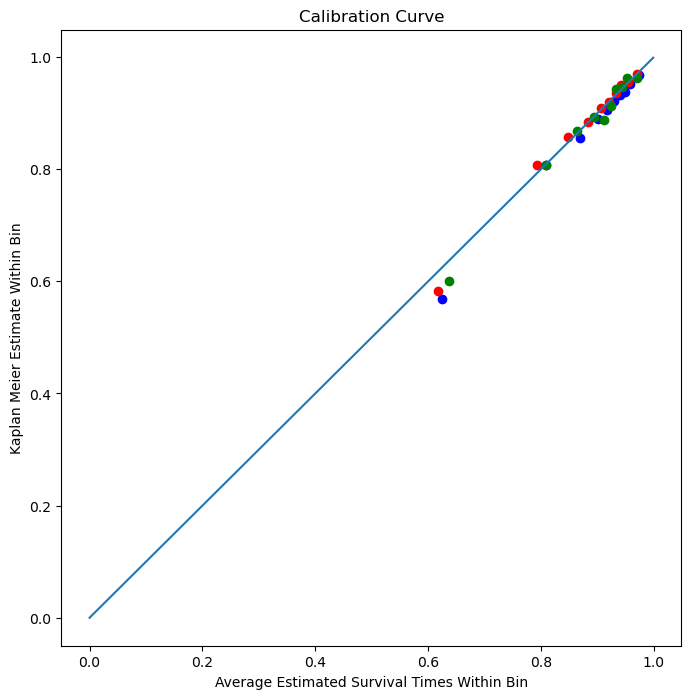

5000/5000 [==============================] - 4s 871us/step
0
16.918977604620448 136.21972415479948 REJ 126.01203675964247 REJ
0
16.918977604620448 114.44149266091969 REJ 115.54991463480708 REJ
0
16.918977604620448 14.712345384906117 FTR 13.63578511407964 FTR


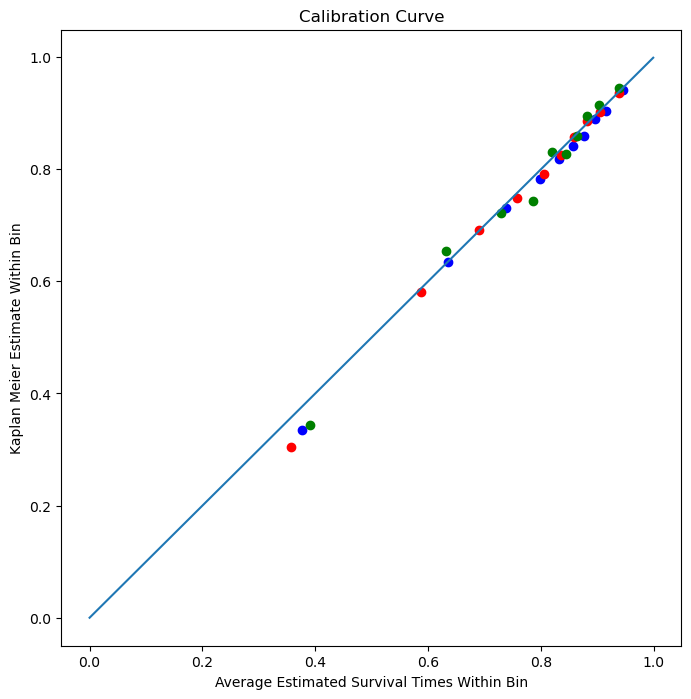

5000/5000 [==============================] - 4s 810us/step
0
16.918977604620448 98.19973279678297 REJ 87.04382124140001 REJ
0
16.918977604620448 139.71507617118246 REJ 133.37713019913076 REJ
0
16.918977604620448 13.266425884951378 FTR 14.013748312051309 FTR


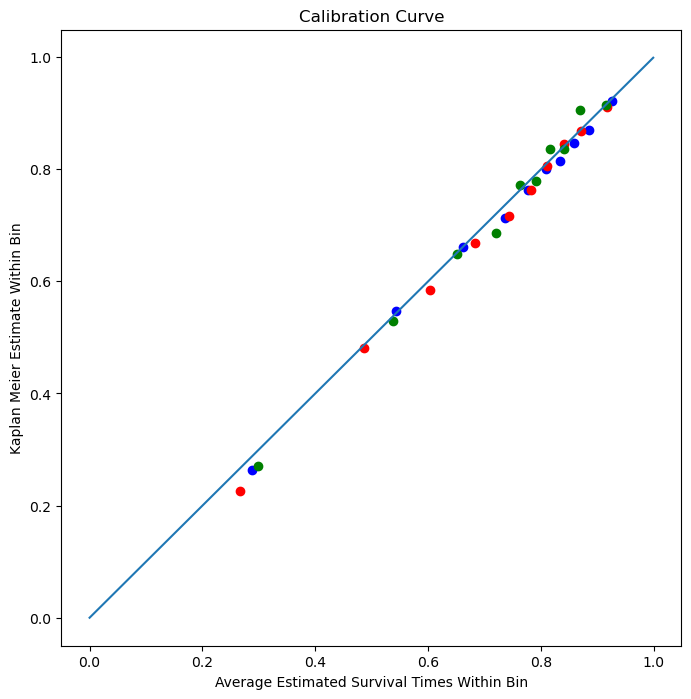

In [63]:
WIND = TRAIN.RACEGENDER['RACE'] == 'WHITE'
BIND = TRAIN.RACEGENDER['RACE'] == 'BLACK'
OIND = ~((TRAIN.RACEGENDER['RACE'] == 'WHITE') | (TRAIN.RACEGENDER['RACE'] == 'BLACK'))
MIND = TRAIN.RACEGENDER['MALE'] == 1
FIND = TRAIN.RACEGENDER['MALE'] == 0
tpts = [1.,3.,5.]
for tpt in tpts:
    TRAIN_preds = modm.predict_surv(TRAIN.X, tpt)
    WCAL = km_surv_cal(TRAIN_preds[WIND],
                    TRAIN.Y['YTIME'][WIND], 
                    TRAIN.Y['OBSERVED'][WIND],
                    n_bins=10,
                    time_window=tpt,
                    plot_cal=False)
    WCAL.to_csv(
        path.join(
            here(),
            'reset_project_data/2021-06-09-wrace-white-TRAIN_cal_' + str(tpt)+ 'yearsurv.csv'))
    BCAL = km_surv_cal(TRAIN_preds[BIND],
                    TRAIN.Y['YTIME'][BIND], 
                    TRAIN.Y['OBSERVED'][BIND],
                    n_bins=10,
                    time_window=tpt,
                    plot_cal=False)
    BCAL.to_csv(
        path.join(
            here(),
            'reset_project_data/2021-06-09-wrace-black-TRAIN_cal_' + str(tpt)+ 'yearsurv.csv'))
    OCAL = km_surv_cal(TRAIN_preds[OIND],
                    TRAIN.Y['YTIME'][OIND], 
                    TRAIN.Y['OBSERVED'][OIND],
                    n_bins=10,
                    time_window=tpt,
                    plot_cal=False)
    OCAL.to_csv(
        path.join(
            here(),
            'reset_project_data/2021-06-09-wrace-other-TRAIN_cal_' + str(tpt)+ 'yearsurv.csv'))
    
    fig, ax = plt.subplots()
    fig.set_size_inches([8,8])
    ax.plot(np.arange(0,1,0.001),np.arange(0,1,0.001))
    ax.scatter(WCAL['ESTS'],
               WCAL['KM'], 
               color = 'blue')
    ax.scatter(BCAL['ESTS'],
               BCAL['KM'], 
               color = 'red')
    ax.scatter(OCAL['ESTS'],
               OCAL['KM'], 
               color = 'green')
    
    plt.xlabel('Average Estimated Survival Times Within Bin')
    plt.ylabel('Kaplan Meier Estimate Within Bin')
    plt.title('Calibration Curve')
    plt.show()
    

1250/1250 [==============================] - 1s 747us/step
0
16.918977604620448 90.81949733390164 REJ 75.81208940129684 REJ
0
16.918977604620448 22.683305193888444 REJ 22.064414090682448 REJ
0
16.918977604620448 10.458189731942456 FTR 9.440641820962888 FTR


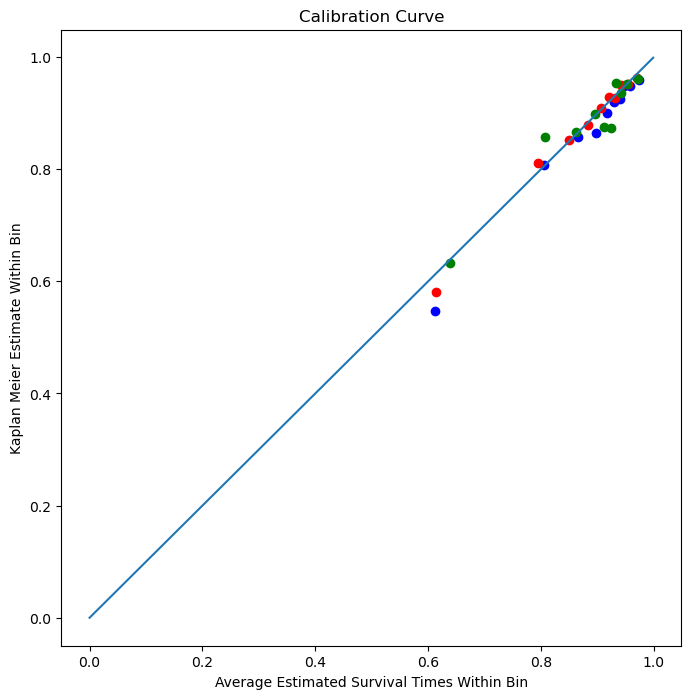

1250/1250 [==============================] - 1s 823us/step
0
16.918977604620448 65.74176982002001 REJ 55.394470649732476 REJ
0
16.918977604620448 28.93535092648171 REJ 26.9643508732497 REJ
0
16.918977604620448 6.653535057882328 FTR 6.723775921188515 FTR


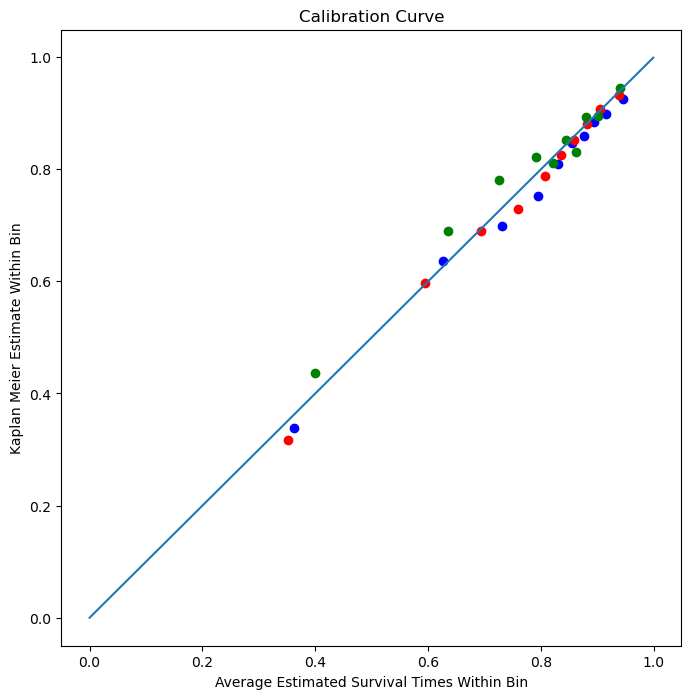

1250/1250 [==============================] - 1s 965us/step
0
16.918977604620448 70.13534449979804 REJ 57.867009945264215 REJ
0
16.918977604620448 40.72860341413217 REJ 35.99039611470774 REJ
0
16.918977604620448 6.049667819839674 FTR 5.503637102169851 FTR


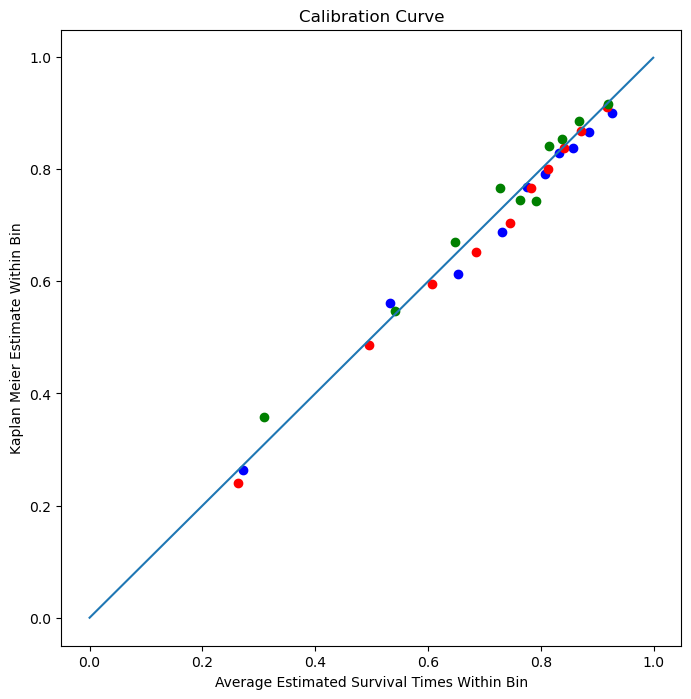

In [64]:
WIND = VAL.RACEGENDER['RACE'] == 'WHITE'
BIND = VAL.RACEGENDER['RACE'] == 'BLACK'
OIND = ~((VAL.RACEGENDER['RACE'] == 'WHITE') | (VAL.RACEGENDER['RACE'] == 'BLACK'))
MIND = VAL.RACEGENDER['MALE'] == 1
FIND = VAL.RACEGENDER['MALE'] == 0
tpts = [1.,3.,5.]
for tpt in tpts:
    VAL_preds = modm.predict_surv(VAL.X, tpt)
    WCAL = km_surv_cal(VAL_preds[WIND],
                    VAL.Y['YTIME'][WIND], 
                    VAL.Y['OBSERVED'][WIND],
                    n_bins=10,
                    time_window=tpt,
                    plot_cal=False)
    WCAL.to_csv(
        path.join(
            here(),
            'reset_project_data/2021-06-09-wrace-white-VAL_cal_' + str(tpt)+ 'yearsurv.csv'))
    
    BCAL = km_surv_cal(VAL_preds[BIND],
                    VAL.Y['YTIME'][BIND], 
                    VAL.Y['OBSERVED'][BIND],
                    n_bins=10,
                    time_window=tpt,
                    plot_cal=False)
    BCAL.to_csv(
        path.join(
            here(),
            'reset_project_data/2021-06-09-wrace-black-VAL_cal_' + str(tpt)+ 'yearsurv.csv'))
    
    OCAL = km_surv_cal(VAL_preds[OIND],
                    VAL.Y['YTIME'][OIND], 
                    VAL.Y['OBSERVED'][OIND],
                    n_bins=10,
                    time_window=tpt,
                    plot_cal=False)
    OCAL.to_csv(
        path.join(
            here(),
            'reset_project_data/2021-06-09-wrace-other-VAL_cal_' + str(tpt)+ 'yearsurv.csv'))
    
    fig, ax = plt.subplots()
    fig.set_size_inches([8,8])
    ax.plot(np.arange(0,1,0.001),np.arange(0,1,0.001))
    ax.scatter(WCAL['ESTS'],
               WCAL['KM'], 
               color = 'blue')
    ax.scatter(BCAL['ESTS'],
               BCAL['KM'], 
               color = 'red')
    ax.scatter(OCAL['ESTS'],
               OCAL['KM'], 
               color = 'green')
    
    plt.xlabel('Average Estimated Survival Times Within Bin')
    plt.ylabel('Kaplan Meier Estimate Within Bin')
    plt.title('Calibration Curve')
    plt.show()
    

# Partial Dependence Plots

In [65]:
def pdp_oneval(mod, X, colname, corrcols, new_val, tval=5):
    XPERM = X.copy()
    XPERM[colname] = new_val
    preds = mod.predict_surv(XPERM, time = tval)
    avgval = preds.mean()
    lowerval = np.quantile(preds, 0.05)
    upperval = np.quantile(preds, 0.95)
    return [avgval, lowerval, upperval]

In [66]:
gender_cols = pattern_match_cols('MALE', TEST.X)
age_cols = [i for (i,x) in enumerate(TEST.X.columns) if x in ['FIRSTCONV_AGE','AGEATDATE']]
race_cols = pattern_match_cols('RACE', TEST.X)
prior_cols = [i for (i,x) in enumerate(TEST.X.columns) if x in ['EVENTSBEFOREDATE','N_PRIOR_FELONY', 'N_PRIOR_MISD']]
eventcount_cols = [i for (i,x) in enumerate(TEST.X.columns) if x in ['EVENTSONDATE','N_FELONY', 'N_MISD']]
prison_cols = [i for (i,x) in enumerate(TEST.X.columns) if x in ['FROMPRISON', 'INCTIME', 'COMMUNITY']]
priorprison_cols = [i for (i,x) in enumerate(TEST.X.columns) if x in ['PRIOR_INCTIME','PRIOR_PRISONSPELLS']]
minmax_cols = [i for (i,x) in enumerate(TEST.X.columns) if x in ['TOTAL_MIN_SENTENCE_TIME', 'AVG_MIN_SENTENCE_TIME', 'TOTAL_MAX_SENTENCE_TIME', 'AVG_MAX_SENTENCE_TIME', 'ANY_CONSECUTIVE', 'ANY_CONCURRENT']]
aggdate_cols = pattern_match_cols('AGG_DATE', TEST.X)
aggprior_cols = pattern_match_cols('AGG_PRIOR', TEST.X)

In [67]:
def pdp_group_byvalue(mod, X, colname, corrcols, new_val, tval=5):
    G = X.copy()
    n_obs = G.shape[0]
    coldat = G[G.columns[corrcols]].copy()
    NEWDAT = coldat[coldat[colname] == new_val].sample(n = n_obs, replace = True)
    G[G.columns[corrcols]] = NEWDAT[G.columns[corrcols]].values
    preds = mod.predict_surv(G, time = tval)
    avgval = preds.mean()
    lowerval = np.quantile(preds, 0.05)
    upperval = np.quantile(preds, 0.95)
    return [avgval, lowerval, upperval]

def plot_pdp_group_by_value(mod, X, colname, corrcols, newvals, tval=5,
                           xlab = None, 
                           ylab = None,
                           ttl = None,):
    
    if ttl is None:
        ttl = "Correlated PDP Plot: {}".format(colname)
        
    if ylab is None:
        ylab = 'Estimated {}-Year Survival'.format(tval)
        
    if xlab is None:
        xlab = 'Covariate Value'
        
    pdpres = pd.DataFrame([pdp_group_byvalue(mod, X, colname, corrcols, x, tval) for x in newvals], 
                          columns = ['Average', 'Lower05', 'Upper95'])
    
    fig, ax = plt.subplots()
    fig.set_size_inches([8,5])
    
    plt.grid(color = '0.9')
    ax.plot(newvals, pdpres['Average'])
    ax.plot(newvals, pdpres['Lower05'], ":", color = 'C3', mec=1)
    ax.plot(newvals, pdpres['Upper95'], ":", color = 'C3')
    
    plt.ylim([0,1])
    plt.title(ttl)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    fig.tight_layout()
    plt.show()
    return pdpres

print(pdp_group_byvalue(modm, TEST.X, 'AGEATDATE', age_cols, 25, 5))
print(pdp_group_byvalue(modm, TEST.X, 'FIRSTCONV_AGE', age_cols, 25, 5))

1563/1563 [==============================] - 1s 912us/step
[0.6572807, 0.2176745340228081, 0.8445803940296173]
1563/1563 [==============================] - 1s 799us/step
[0.6935899, 0.2410464204847813, 0.9069412350654602]


In [68]:
np.arange(18,66,1)

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65])

1563/1563 [==============================] - 1s 803us/step


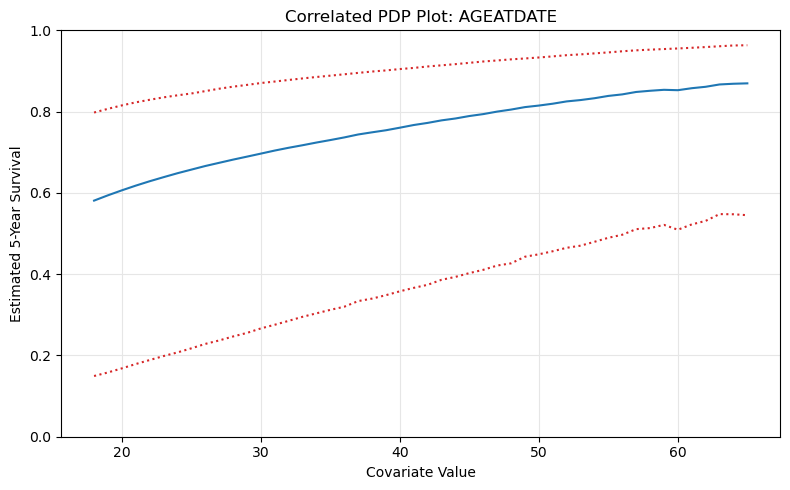

In [69]:
PDPRES = plot_pdp_group_by_value(modm, TEST.X, 'AGEATDATE', age_cols, np.arange(18,66,1), 5)

In [70]:
TEST.X['INCTIME'].max()
np.logspace(np.log(0.001), np.log(8000), base = np.exp(1))

array([1.00000000e-03, 1.38318219e-03, 1.91319296e-03, 2.64629443e-03,
       3.66030732e-03, 5.06287188e-03, 7.00287420e-03, 9.68625086e-03,
       1.33978497e-02, 1.85316670e-02, 2.56326717e-02, 3.54546549e-02,
       4.90402471e-02, 6.78315963e-02, 9.38234557e-02, 1.29774933e-01,
       1.79502375e-01, 2.48284488e-01, 3.43422681e-01, 4.75016136e-01,
       6.57033858e-01, 9.08797528e-01, 1.25703255e+00, 1.73870504e+00,
       2.40494584e+00, 3.32647824e+00, 4.60112545e+00, 6.36419477e+00,
       8.80284084e+00, 1.21759327e+01, 1.68415332e+01, 2.32949087e+01,
       3.22211027e+01, 4.45676554e+01, 6.16451870e+01, 8.52665247e+01,
       1.17939138e+02, 1.63131315e+02, 2.25640329e+02, 3.12101684e+02,
       4.31693490e+02, 5.97110746e+02, 8.25912948e+02, 1.14238808e+03,
       1.58013084e+03, 2.18560883e+03, 3.02309521e+03, 4.18149144e+03,
       5.78376448e+03, 8.00000000e+03])

In [58]:
# PDPRES = plot_pdp_group_by_value(modm, TEST.X, 'INCTIME', prison_cols, np.logspace(np.log(0.001), np.log(8000), base = np.exp(1)), 5)

In [59]:
# PDPRES = plot_pdp_group_by_value(modm, TEST.X, 'FIRSTCONV_AGE', age_cols, np.arange(18,66,1), 5)

In [60]:
# PDPRES = plot_pdp_group_by_value(modm, TEST.X, 'EVENTSONDATE', eventcount_cols, np.arange(1,11,1), 5)

In [61]:
# PDPRES = plot_pdp_group_by_value(modm, TEST.X, 'EVENTSBEFOREDATE', prior_cols, np.arange(1,11,1), 5)

In [62]:
# [*eventcount_cols, *aggdate_cols]

In [63]:
# PDPRES = plot_pdp_group_by_value(modm, TEST.X, 'EVENTSONDATE', [*eventcount_cols, *aggdate_cols], np.arange(1,11,1), 5)

In [64]:
# predY = modm.predict_surv(TEST.X, time = 3)
# Xval = TEST.X['AGEATDATE']
# fig, ax = plt.subplots()
# fig.set_size_inches([8,5])

# plt.grid(color = '0.9')
# ax.scatter(Xval, predY)
# plt.ylim([0,1])
# fig.tight_layout()
# plt.show()


In [71]:
Q = [pdp_oneval(modm, TEST.X, 'INCTIME', prison_cols, x, 3)[0] for x in np.logspace(np.log(0.001), np.log(8000), base = np.exp(1))]

1563/1563 [==============================] - 1s 814us/step


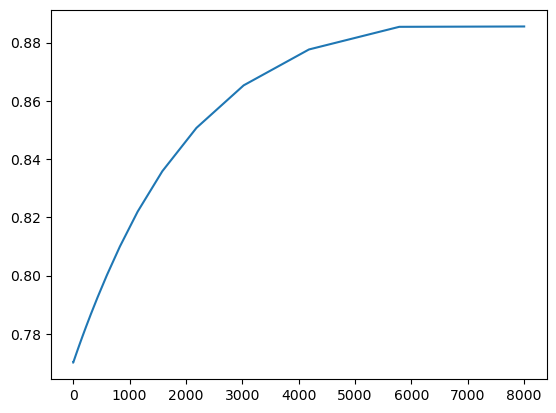

In [72]:
plt.plot(np.logspace(np.log(0.001), np.log(8000), base = np.exp(1)), Q)

In [73]:
np.sort(TRAIN.Y['YTIME'])

array([2.73785079e-03, 2.73785079e-03, 2.73785079e-03, ...,
       2.52648871e+01, 2.52648871e+01, 2.52676249e+01])

In [74]:
TRAIN.Y['OBSERVED'] == 1

322558      True
2306537     True
1847333     True
2107209     True
117846     False
           ...  
2912341    False
2286500    False
2659344    False
1846481    False
1232306    False
Name: OBSERVED, Length: 160000, dtype: bool

In [75]:
tpt = 1
TIMES, COUNTS = np.unique(TRAIN.Y['YTIME'][TRAIN.Y['OBSERVED'] == 1], return_counts = True)
RISKSET = [np.sum(TRAIN.Y['YTIME'] >= time) for time in TIMES]
vdat = pd.DataFrame({'TIMES':TIMES,
                     'COUNTS':COUNTS, 
                     'NRISK':RISKSET})
vdat['EST'] = vdat['COUNTS'] / (vdat['NRISK'] * (vdat['NRISK'] - vdat['COUNTS']))
vdat['EST'][vdat['TIMES'] <= tpt].sum()

8.936544796624855e-07

In [76]:
vdat.head()

,TIMES,COUNTS,NRISK,EST
0,0.002738,344,160000,1.346645e-08
1,0.005476,138,159653,5.418767e-09
2,0.008214,93,159513,3.657161e-09
3,0.010951,75,159417,2.952544e-09
4,0.013689,90,159341,3.546768e-09


1/1 [==============================] - 0s 17ms/step


(0.0, 1.0)

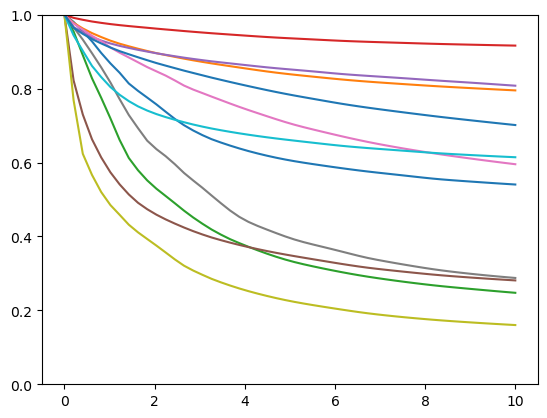

In [78]:
XVALS = np.linspace(0,10,50)
PREDS = [modm.predict_surv(TEST.X.iloc[10:21], time=x) for x in XVALS]
plt.plot(XVALS, PREDS)
plt.ylim([0,1])

In [80]:
PREDS

[array([0.9999999 , 1.        , 0.99999994, 0.99999994, 1.0000001 ,
        1.0000001 , 0.99999994, 1.        , 1.        , 1.        ,
        1.0000001 ], dtype=float32),
 array([0.98050725, 0.9778534 , 0.95445126, 0.9913571 , 0.9662508 ,
        0.8220117 , 0.9758116 , 0.96594155, 0.7685413 , 0.9441229 ,
        0.9645708 ], dtype=float32),
 array([0.95468783, 0.96270597, 0.89059776, 0.9861616 , 0.9525455 ,
        0.7299704 , 0.95955026, 0.9325325 , 0.6235652 , 0.90208745,
        0.9481225 ], dtype=float32),
 array([0.92779106, 0.9501224 , 0.8278562 , 0.9815319 , 0.93916756,
        0.6628657 , 0.94290555, 0.89569193, 0.56641364, 0.86134267,
        0.9340675 ], dtype=float32),
 array([0.89647233, 0.93945366, 0.7751148 , 0.97783697, 0.92995644,
        0.61383694, 0.92828715, 0.8574283 , 0.52008295, 0.83121014,
        0.922196  ], dtype=float32),
 array([0.86822486, 0.9296795 , 0.71953124, 0.9745367 , 0.92205375,
        0.5735032 , 0.9113565 , 0.81661856, 0.48490283, 0.804298  ,

1/1 [==============================] - 0s 17ms/step


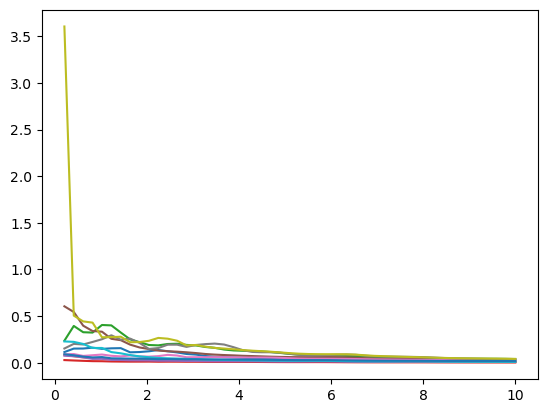

In [81]:
def predict_hazard(model, newdat, time=1):
    # Predict survival at time t for a set of new data
    # Get new weights from estimated model
    wt_preds = model.model.predict(newdat)

    # Estimate survival functions for all parameters
    SS = tfp.distributions.Weibull(
        concentration=model.pars.numpy()[:,0], 
        scale=model.pars.numpy()[:,1]
    ).survival_function(time).numpy()
    
    FS = tfp.distributions.Weibull(
        concentration=model.pars.numpy()[:,0], 
        scale=model.pars.numpy()[:,1]
    ).prob(time).numpy()

    # weighted average 
    survs_out = np.dot(wt_preds, SS)
    pdfs_out = np.dot(wt_preds, FS)
    hazard_out = pdfs_out / survs_out
    return hazard_out


XVALS = np.linspace(0,10,50)
PREDS = [predict_hazard(modm, TEST.X.iloc[10:21], time=x) for x in XVALS]
plt.plot(XVALS, PREDS)
plt.show()
# plt.ylim([0,1])